In [179]:
# Cosas para el cleaning:
# Algunos años de draft tienen incompleto el número de pick (aplicar orden)
# Hacer correspondencia de los equipos antiguos con los nuevos (Draft i basic -> nueva columna)
# Se puede hacer un estudio de si en los últimos 10 años podemos asegurar que el % de tiro de 3 ha augmentado

#Cosas para hacer en feature engineering
#Añadir columna de has played play-off
# Has won NBA
# Active/inactive player
# w/l  de l'equip que el va draftejar

## 46-49 es ABA y no NBA -> borramos registros de antes??? (cleaning)

# 2. Data Cleaning

First, we import the Python packages we'll be using in the entire notebook

In [180]:
#pip install progressbar
#pip install XXXXXXXXXXX [other packages needed]

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import sys
import string
import missingno as msno 
import seaborn as sn
import requests
import datetime
import progressbar
import time
import re
from selenium import webdriver
#from matplotlib import pyplot
from webdriver_manager.chrome import ChromeDriverManager
from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

## 2.1 Importing the raw files

In [181]:
df_basic_info_raw = pd.read_excel('Scraped data/Basic_Info_Raw.xlsx',index_col=0)
df_draft_raw = pd.read_excel('Scraped data/All_drafts_raw.xlsx',index_col=0)
df_teams_raw = pd.read_excel('Scraped data/All_time_teams_raw.xlsx',index_col=0)
df_complete_players_raw = pd.read_excel('Scraped data/NBA_Complete_Raw.xlsx',index_col=0)

## 2.2 Data cleaning

Explicación de lo que haremos en general para cada Dataset... Aquí podemos decidir borrar ABA y BAA porque aportan ruido al dataset

### 2.2.1 Basic_info

In [182]:
df_basic_info_raw.head()

player_url          player_name  active_from  active_to  \
0  /players/a/abdelal01.html       Alaa Abdelnaby         1991       1995   
1  /players/a/abdulza01.html      Zaid Abdul-Aziz         1969       1978   
2  /players/a/abdulka01.html  Kareem Abdul-Jabbar         1970       1989   
3  /players/a/abdulma02.html   Mahmoud Abdul-Rauf         1991       2001   
4  /players/a/abdulta01.html    Tariq Abdul-Wahad         1998       2003   

  position                   college height  weight        birth_date  
0      F-C                      Duke   6-10   240.0     June 24, 1968  
1      C-F                Iowa State    6-9   235.0     April 7, 1946  
2        C                      UCLA    7-2   225.0    April 16, 1947  
3        G                       LSU    6-1   162.0     March 9, 1969  
4        F  Michigan, San Jose State    6-6   223.0  November 3, 1974

In [183]:
df_basic_info_raw.dtypes

player_url      object
player_name     object
active_from      int64
active_to        int64
position        object
college         object
height          object
weight         float64
birth_date      object
dtype: object

In [184]:
# profile_basic_info = df_basic_info_raw.profile_report()
# profile_basic_info.to_file("Reports/Raw_data/report_basic_info_raw.html")

The first thing to do is to correct the data type and format of some columns (creating new ones in some cases):

In [185]:
df_basic_info = df_basic_info_raw.copy()

#df_basic_info['birth_date'] = df_basic_info['birth_date'].apply(pd.to_datetime)
#df_basic_info['birth_date'] = pd.to_datetime(df_basic_info['birth_date']).dt.date
df_basic_info['birth_date(year)'] = pd.to_datetime(df_basic_info['birth_date']).dt.strftime("%Y")
# Pasamos la fecha de nacimiento a solo el año

df_basic_info['height(cm)'] = df_basic_info['height'].apply(lambda x: float(x[:1])*30.48 + float(x[2:])*2.54 )

In [186]:
df_basic_info_raw.head()

player_url          player_name  active_from  active_to  \
0  /players/a/abdelal01.html       Alaa Abdelnaby         1991       1995   
1  /players/a/abdulza01.html      Zaid Abdul-Aziz         1969       1978   
2  /players/a/abdulka01.html  Kareem Abdul-Jabbar         1970       1989   
3  /players/a/abdulma02.html   Mahmoud Abdul-Rauf         1991       2001   
4  /players/a/abdulta01.html    Tariq Abdul-Wahad         1998       2003   

  position                   college height  weight        birth_date  
0      F-C                      Duke   6-10   240.0     June 24, 1968  
1      C-F                Iowa State    6-9   235.0     April 7, 1946  
2        C                      UCLA    7-2   225.0    April 16, 1947  
3        G                       LSU    6-1   162.0     March 9, 1969  
4        F  Michigan, San Jose State    6-6   223.0  November 3, 1974

In [187]:
df_basic_info.head()

player_url          player_name  active_from  active_to  \
0  /players/a/abdelal01.html       Alaa Abdelnaby         1991       1995   
1  /players/a/abdulza01.html      Zaid Abdul-Aziz         1969       1978   
2  /players/a/abdulka01.html  Kareem Abdul-Jabbar         1970       1989   
3  /players/a/abdulma02.html   Mahmoud Abdul-Rauf         1991       2001   
4  /players/a/abdulta01.html    Tariq Abdul-Wahad         1998       2003   

  position                   college height  weight        birth_date  \
0      F-C                      Duke   6-10   240.0     June 24, 1968   
1      C-F                Iowa State    6-9   235.0     April 7, 1946   
2        C                      UCLA    7-2   225.0    April 16, 1947   
3        G                       LSU    6-1   162.0     March 9, 1969   
4        F  Michigan, San Jose State    6-6   223.0  November 3, 1974   

  birth_date(year)  height(cm)  
0             1968      208.28  
1             1946      205.74  
2             1947      218.44  
3             1969      185.42  
4             1974      198.12

As we can see in the report, there are only two clumns with some missings:

In [188]:
df_basic_info_raw.isnull().sum()

player_url       0
player_name      0
active_from      0
active_to        0
position         0
college        353
height           0
weight           5
birth_date      18
dtype: int64

In [189]:
df_basic_info[df_basic_info['college'].isna()]
# As we can see Álex Abrines, former player of Oklahoma City Thunder hadn't gone to college (FC Barcelona was 
# the las Europe's team before going to the NBA).

player_url               player_name  active_from  \
9     /players/a/abrinal01.html              Álex Abrines         2017   
35    /players/a/ajincal01.html             Alexis Ajinça         2009   
43    /players/a/aldemfu01.html            Furkan Aldemir         2015   
85    /players/a/anderda03.html            David Andersen         2010   
111   /players/a/andrima01.html  Martynas Andriuškevičius         2006   
...                         ...                       ...          ...   
4963    /players/y/yuesu01.html                   Sun Yue         2009   
4975  /players/z/zhizhwa01.html               Wang Zhizhi         2001   
4979  /players/z/zipsepa01.html               Paul Zipser         2017   
4980  /players/z/zizican01.html                Ante Žižić         2018   
4983  /players/z/zubaciv01.html               Ivica Zubac         2017   

      active_to position college height  weight         birth_date  \
9          2019      G-F     NaN    6-6   200.0     August 1, 1993   
35         2017      C-F     NaN    7-2   248.0        May 6, 1988   
43         2015      F-C     NaN   6-10   240.0     August 9, 1991   
85         2011        C     NaN   6-11   245.0      June 23, 1980   
111        2006        C     NaN    7-2   240.0     March 12, 1986   
...         ...      ...     ...    ...     ...                ...   
4963       2009        G     NaN    6-9   205.0   November 6, 1985   
4975       2005        C     NaN    7-0   255.0       July 8, 1977   
4979       2018      G-F     NaN    6-8   215.0  February 18, 1994   
4980       2020      F-C     NaN   6-10   266.0    January 4, 1997   
4983       2022        C     NaN    7-0   240.0     March 18, 1997   

     birth_date(year)  height(cm)  
9                1993      198.12  
35               1988      218.44  
43               1991      208.28  
85               1980      210.82  
111              1986      218.44  
...               ...         ...  
4963             1985      205.74  
4975             1977      213.36  
4979             1994      203.20  
4980             1997      208.28  
4983             1997      213.36  

[353 rows x 11 columns]

In [190]:
df_basic_info[df_basic_info['birth_date'].isna()]
#we observe that in their main player pages they have a reference for born date (POSAR FOTO)

player_url        player_name  active_from  active_to  \
58    /players/a/allenbi01.html         Bill Allen         1968       1968   
525   /players/b/brookcl01.html  Clarence Brookins         1971       1971   
648    /players/b/byrdwa01.html        Walter Byrd         1970       1970   
1787  /players/h/hardyda01.html      Darrell Hardy         1968       1968   
2432  /players/k/kirklwi01.html    Wilbur Kirkland         1970       1970   
2589    /players/l/leedi01.html           Dick Lee         1968       1968   
2707  /players/l/lynamrb01.html         R.B. Lynam         1968       1968   
2867  /players/m/mccarho01.html      Howie McCarty         1947       1947   
3100  /players/m/mooreri01.html       Richie Moore         1968       1968   
3398  /players/p/palmeer01.html       Errol Palmer         1968       1968   
3417  /players/p/parksch01.html      Charles Parks         1969       1969   
4137  /players/s/smithpe01.html         Pete Smith         1973       1973   
4243  /players/s/stollra01.html        Randy Stoll         1968       1968   
4377  /players/t/thomawi01.html      Willis Thomas         1968       1968   
4478  /players/t/turnega01.html        Gary Turner         1968       1968   
4703  /players/w/westbde01.html   Dexter Westbrook         1968       1968   
4857  /players/w/wilsobo02.html       Bobby Wilson         1968       1968   
4865  /players/w/wilsoji01.html         Jim Wilson         1971       1971   

     position                         college height  weight birth_date  \
58        C-F                New Mexico State    6-8   205.0        NaN   
525         F                          Temple    6-4   190.0        NaN   
648         F                          Temple    6-7   205.0        NaN   
1787        F                          Baylor    6-7   220.0        NaN   
2432        F                    Cheyney (PA)    6-7   190.0        NaN   
2589        F                      Washington    6-6     NaN        NaN   
2707        G     Oklahoma Baptist University    6-1   190.0        NaN   
2867      F-G          Wayne State University    6-2   190.0        NaN   
3100        G  Villanova, Hiram Scott College    6-2   190.0        NaN   
3398        F                          DePaul    6-5   195.0        NaN   
3417        F          Idaho State University    6-5   210.0        NaN   
4137        F       Valdosta State University    6-6   205.0        NaN   
4243        C                Washington State    6-7   235.0        NaN   
4377        G                  Harbor College    6-2   185.0        NaN   
4478        F                             TCU    6-7   200.0        NaN   
4703        F                      Providence    6-8   190.0        NaN   
4857        F                          Kansas    6-8   215.0        NaN   
4865        G                    Cheyney (PA)   5-10   175.0        NaN   

     birth_date(year)  height(cm)  
58                NaN      203.20  
525               NaN      193.04  
648               NaN      200.66  
1787              NaN      200.66  
2432              NaN      200.66  
2589              NaN      198.12  
2707              NaN      185.42  
2867              NaN      187.96  
3100              NaN      187.96  
3398              NaN      195.58  
3417              NaN      195.58  
4137              NaN      198.12  
4243              NaN      200.66  
4377              NaN      187.96  
4478              NaN      200.66  
4703              NaN      203.20  
4857              NaN      203.20  
4865              NaN      177.80

In [191]:
def fill_nan_birthdates(player_url):
    
    born = np.nan
    
    page_request = requests.get('https://www.basketball-reference.com' + str(player_url))
    soup = BeautifulSoup(page_request.text,"lxml")
    bold_characters = soup.findAll('p')
    
    try:
        aux = str(soup.findAll('p'))
        born = re.search(r'/strong>(.*?)\n  <span', aux).group(1)
    except:
        pass
    
    return born

In [192]:
non_birthdate_players = df_basic_info[df_basic_info['birth_date(year)'].isna()].index

for i in non_birthdate_players:
    df_basic_info.loc[i,'birth_date(year)'] = fill_nan_birthdates(df_basic_info['player_url'][i])

In [193]:
df_basic_info[df_basic_info['birth_date(year)'].isna()]
#There is no info in Wikipedia, we will fill the NaN with K-NN

player_url player_name  active_from  active_to position  \
2589  /players/l/leedi01.html    Dick Lee         1968       1968        F   

         college height  weight birth_date birth_date(year)  height(cm)  
2589  Washington    6-6     NaN        NaN              NaN      198.12

In [194]:
df_basic_info[df_basic_info['weight'].isna()]
#we observe that the info is not in the basketball-reference web, so we'll search it in the Wikipedia:
# https://es.wikipedia.org/wiki/Paul_Nolen
# https://es.wikipedia.org/wiki/Ray_Wertis
# https://es.wikipedia.org/wiki/Bob_Wood
# Dick Lee and Murray Mitchell not found

player_url      player_name  active_from  active_to  \
2589    /players/l/leedi01.html         Dick Lee         1968       1968   
3056  /players/m/mitchmu01.html  Murray Mitchell         1950       1950   
3264  /players/n/nolenpa01.html       Paul Nolen         1954       1954   
4693  /players/w/wertira01.html       Ray Wertis         1947       1948   
4902   /players/w/woodbo01.html         Bob Wood         1950       1950   

     position                       college height  weight         birth_date  \
2589        F                    Washington    6-6     NaN                NaN   
3056        C  Sam Houston State University    6-6     NaN     March 19, 1923   
3264        C                    Texas Tech   6-10     NaN  September 3, 1929   
4693        G                    St. John's   5-11     NaN      July 30, 1923   
4902        G             Northern Illinois   5-10     NaN    October 7, 1921   

     birth_date(year)  height(cm)  
2589              NaN      198.12  
3056             1923      198.12  
3264             1929      208.28  
4693             1923      180.34  
4902             1921      177.80

In [195]:
df_basic_info.loc[3264,'weight'] = 213
df_basic_info.loc[4693,'weight'] = 169
df_basic_info.loc[4902,'weight'] = 174

In [196]:
df_basic_info[df_basic_info['weight'].isna()]
#There is no info in Wikipedia, we will fill the NaN with K-NN

player_url      player_name  active_from  active_to  \
2589    /players/l/leedi01.html         Dick Lee         1968       1968   
3056  /players/m/mitchmu01.html  Murray Mitchell         1950       1950   

     position                       college height  weight      birth_date  \
2589        F                    Washington    6-6     NaN             NaN   
3056        C  Sam Houston State University    6-6     NaN  March 19, 1923   

     birth_date(year)  height(cm)  
2589              NaN      198.12  
3056             1923      198.12

#### Fill NANs

In [197]:
df_basic_info.isnull().sum()

player_url            0
player_name           0
active_from           0
active_to             0
position              0
college             353
height                0
weight                2
birth_date           18
birth_date(year)      1
height(cm)            0
dtype: int64

In [198]:
df_basic_info['college'] = df_basic_info['college'].fillna('No College')

In [199]:
df_basic_info_2 = df_basic_info.copy()

imputer = KNNImputer(n_neighbors=10)
imputed_data = imputer.fit_transform(df_basic_info_2[['weight','height(cm)','active_from','birth_date(year)']])
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = ['weight','height(cm)','active_from','birth_date(year)']
df_basic_info_2['weight'] = df_temp['weight'].astype(int)
df_basic_info_2['birth_date(year)'] = df_temp['birth_date(year)'].astype(int)

In [200]:
df_basic_info_2.isnull().sum()

player_url           0
player_name          0
active_from          0
active_to            0
position             0
college              0
height               0
weight               0
birth_date          18
birth_date(year)     0
height(cm)           0
dtype: int64

In [201]:
df_basic_info_2.loc[2589,]

player_url          /players/l/leedi01.html
player_name                        Dick Lee
active_from                            1968
active_to                              1968
position                                  F
college                          Washington
height                                  6-6
weight                                  215
birth_date                              NaN
birth_date(year)                       1942
height(cm)                           198.12
Name: 2589, dtype: object

##### Save a clean copy of the dataset

In [202]:
df_basic_info_clean = df_basic_info_2.copy()
df_basic_info_clean = df_basic_info_clean.drop(columns=['birth_date'])

In [203]:
df_basic_info_clean.head()

player_url          player_name  active_from  active_to  \
0  /players/a/abdelal01.html       Alaa Abdelnaby         1991       1995   
1  /players/a/abdulza01.html      Zaid Abdul-Aziz         1969       1978   
2  /players/a/abdulka01.html  Kareem Abdul-Jabbar         1970       1989   
3  /players/a/abdulma02.html   Mahmoud Abdul-Rauf         1991       2001   
4  /players/a/abdulta01.html    Tariq Abdul-Wahad         1998       2003   

  position                   college height  weight  birth_date(year)  \
0      F-C                      Duke   6-10     240              1968   
1      C-F                Iowa State    6-9     235              1946   
2        C                      UCLA    7-2     225              1947   
3        G                       LSU    6-1     162              1969   
4        F  Michigan, San Jose State    6-6     223              1974   

   height(cm)  
0      208.28  
1      205.74  
2      218.44  
3      185.42  
4      198.12

In [204]:
df_basic_info_clean.to_excel('Clean_data/Basic_Info_Clean.xlsx')

### 2.2.2 Draft

In [205]:
df_draft_raw.head()

draft_year  draft_round  draft_pick_number draft_team      player_name  \
0        2021            1                1.0        DET  Cade Cunningham   
1        2021            1                2.0        HOU      Jalen Green   
2        2021            1                3.0        CLE      Evan Mobley   
3        2021            1                4.0        TOR   Scottie Barnes   
4        2021            1                5.0        ORL      Jalen Suggs   

                  player_url         college  
0  /players/c/cunnica01.html  Oklahoma State  
1  /players/g/greenja05.html             NaN  
2  /players/m/mobleev01.html             USC  
3  /players/b/barnesc01.html   Florida State  
4  /players/s/suggsja01.html         Gonzaga

In [206]:
df_draft_raw.dtypes

draft_year             int64
draft_round            int64
draft_pick_number    float64
draft_team            object
player_name           object
player_url            object
college               object
dtype: object

In [207]:
# profile_draft = df_draft_raw.profile_report()
# profile_draft.to_file("Reports/Raw_data/report_draft_raw.html")

##### Fill Nans

In [208]:
df_draft = df_draft_raw.copy()

In [209]:
df_draft.isnull().sum()

draft_year             0
draft_round            0
draft_pick_number    428
draft_team             0
player_name            0
player_url             0
college              399
dtype: int64

In [210]:
def find_college(player_url):
    try:
        college = df_basic_info_clean.loc[df_basic_info_clean[df_basic_info_clean['player_url'] == player_url].index[0],'college']
    except:
        college = "Not at Basic Info"
    return college

In [211]:
df_draft_1 = df_draft.copy()
no_college_players_index = df_draft_1[df_draft_1['college'].isna()].index
for index in no_college_players_index:
    df_draft_1.loc[index, 'college'] = find_college(df_draft_1.loc[index, 'player_url'])

In [212]:
df_draft_1.isnull().sum()

draft_year             0
draft_round            0
draft_pick_number    428
draft_team             0
player_name            0
player_url             0
college                0
dtype: int64

In [213]:
df_draft_1[df_draft_1['draft_pick_number'].isna()]['draft_year'].unique()

array([1953, 1952, 1949, 1948, 1947], dtype=int64)

In [214]:
df_draft_2 = df_draft_1.copy()

years = df_draft_2[df_draft_2['draft_pick_number'].isna()]['draft_year'].unique()

for year in years:
    indexes = df_draft_2[(df_draft_2['draft_year']==year) & ((df_draft_2['draft_pick_number'].isna()))].index
    aux = 1
    last = len(df_draft_2[(df_draft_1['draft_year']==year) & ((df_draft_2['draft_pick_number'].isna()==False))])
    
    for i in indexes:
        df_draft_2.loc[i, 'draft_pick_number'] = last + aux
        aux = aux + 1
#with this method we are assuming that the order in data stablishes the pick number, which may be not true
# si cortamos los datos al 50, solo nos preocupa que esté bien para el 52 y 53

In [215]:
df_draft_2[(df_draft_2['draft_year']==1949)]

draft_year  draft_round  draft_pick_number draft_team        player_name  \
0         1949            1                4.0        BOS      George Kaftan   
1         1949            1                5.0        STB        Ed Macauley   
2         1949            1                8.0        NYK       Dick McGuire   
3         1949            1               11.0        MNL     Vern Mikkelsen   
4         1949            2               14.0        INO      Leo Barnhorst   
..         ...          ...                ...        ...                ...   
78        1949           13               79.0        PRO        Jack Phelan   
79        1949           13               80.0        ROC       Jim McIntyre   
80        1949           13               81.0        STB     John Pritchard   
81        1949           13               82.0        WSC  Maynard Haithcock   
82        1949           13               83.0        WSC           Jim Lacy   

                   player_url            college  
0   /players/k/kaftage01.html  Not at Basic Info  
1   /players/m/macaued01.html  Not at Basic Info  
2   /players/m/mcguidi01.html  Not at Basic Info  
3   /players/m/mikkeve01.html  Not at Basic Info  
4   /players/b/barnhle01.html  Not at Basic Info  
..                        ...                ...  
78  /players/p/phelaja01.html             DePaul  
79  /players/m/mcintji01.html          Minnesota  
80  /players/p/pritcjo01.html   Drake University  
81  /players/h/haitcma01.html  George Washington  
82   /players/l/lacyji01.html        Loyola (MD)  

[83 rows x 7 columns]

In [216]:
df_draft_2.isnull().sum()

draft_year           0
draft_round          0
draft_pick_number    0
draft_team           0
player_name          0
player_url           0
college              0
dtype: int64

##### Correct data types

In [217]:
df_draft_2['draft_pick_number'] = df_draft_2['draft_pick_number'].astype('int64') 

In [218]:
df_draft_2.dtypes
#now the types are all correct

draft_year            int64
draft_round           int64
draft_pick_number     int64
draft_team           object
player_name          object
player_url           object
college              object
dtype: object

##### Save a clean copy of the dataset

In [219]:
df_draft_clean = df_draft_2.copy()

df_draft_clean.to_excel('Clean_data/All_drafts_Clean.xlsx')

### 2.2.3 Teams standings info

In [220]:
df_teams_raw.head()

team_3_lett   season league       team_name  wins  losses  w_l_pct
0         ATL  2021-22    NBA   Atlanta Hawks    16      19    0.457
1         ATL  2020-21    NBA  Atlanta Hawks*    41      31    0.569
2         ATL  2019-20    NBA   Atlanta Hawks    20      47    0.299
3         ATL  2018-19    NBA   Atlanta Hawks    29      53    0.354
4         ATL  2017-18    NBA   Atlanta Hawks    24      58    0.293

In [221]:
df_teams_raw.dtypes
#They're correct

team_3_lett     object
season          object
league          object
team_name       object
wins             int64
losses           int64
w_l_pct        float64
dtype: object

In [222]:
# profile_teams = df_teams_raw.profile_report()
# profile_teams.to_file("Reports/Raw_data/report_teams_raw.html")

In [223]:
df_teams = df_teams_raw.copy()

In [224]:
df_teams.isnull().sum()
#No Nans to fill

team_3_lett    0
season         0
league         0
team_name      0
wins           0
losses         0
w_l_pct        0
dtype: int64

In [225]:
df_teams['team_3_lett'].unique()
#The actual 30 teams at the nba

array(['ATL', 'BOS', 'NJN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET',
       'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN',
       'NOH', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS',
       'TOR', 'UTA', 'WAS'], dtype=object)

In [226]:
n_teams_x_season = df_teams[['season','team_name']].groupby(by='season').count().reset_index(drop=False) #mirar si con pivot table queda mejor
n_teams_x_season
#know how many teams participated in each season, we can represent that with a visualization

season  team_name
0   1946-47          3
1   1947-48          3
2   1948-49          6
3   1949-50          8
4   1950-51          8
..      ...        ...
71  2017-18         30
72  2018-19         30
73  2019-20         30
74  2020-21         30
75  2021-22         30

[76 rows x 2 columns]

In [227]:
n_teams_x_season.dtypes

season       object
team_name     int64
dtype: object

In [228]:
# n_teams_x_season['team_name'].hist()

In [229]:
n_teams_x_season

season  team_name
0   1946-47          3
1   1947-48          3
2   1948-49          6
3   1949-50          8
4   1950-51          8
..      ...        ...
71  2017-18         30
72  2018-19         30
73  2019-20         30
74  2020-21         30
75  2021-22         30

[76 rows x 2 columns]

In [230]:
df_teams['team_name_clean'] = df_teams['team_name'].apply(lambda x: x[:-1] if '*' in x else x)

In [231]:
df_teams['team_name_clean'].unique()
# No strange names, the New Orleans/Oklahoma City Hornets is checked, a 2006 season team

array(['Atlanta Hawks', 'St. Louis Hawks', 'Milwaukee Hawks',
       'Tri-Cities Blackhawks', 'Boston Celtics', 'Brooklyn Nets',
       'New Jersey Nets', 'New York Nets', 'New Jersey Americans',
       'Charlotte Hornets', 'Charlotte Bobcats', 'Chicago Bulls',
       'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets',
       'Denver Rockets', 'Detroit Pistons', 'Fort Wayne Pistons',
       'Golden State Warriors', 'San Francisco Warriors',
       'Philadelphia Warriors', 'Houston Rockets', 'San Diego Rockets',
       'Indiana Pacers', 'Los Angeles Clippers', 'San Diego Clippers',
       'Buffalo Braves', 'Los Angeles Lakers', 'Minneapolis Lakers',
       'Memphis Grizzlies', 'Vancouver Grizzlies', 'Miami Heat',
       'Milwaukee Bucks', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New Orleans Hornets',
       'New Orleans/Oklahoma City Hornets', 'New York Knicks',
       'Oklahoma City Thunder', 'Seattle SuperSonics', 'Orlando Magic',
       'Philadelphia 76ers',

In [232]:
df_teams['playoff_team'] = df_teams['team_name'].apply(lambda x: 1 if '*' in x else 0)

In [233]:
df_teams_clean = df_teams.copy()
df_teams_clean.to_excel('Clean_data/All_time_teams_clean.xlsx')

##### Now we build a table to unify the team name with the names of the 21-22 season teams

In [234]:
#pd.pivot_table(df_teams[['team_3_lett','team_name']],index = 'team_3_lett')
all_teams = df_teams[['team_3_lett','team_name_clean']].groupby(by='team_name_clean').first().reset_index(level=0, drop=False)
all_teams.head()

team_name_clean team_3_lett
0      Atlanta Hawks         ATL
1  Baltimore Bullets         WAS
2     Boston Celtics         BOS
3      Brooklyn Nets         NJN
4     Buffalo Braves         LAC

In [235]:
df_teams_21 = df_teams[(df_teams['season']=='2021-22')]
all_teams_21 = df_teams_21[['team_3_lett','team_name_clean']].groupby(by='team_name_clean').first().reset_index(level=0, drop=False).rename(columns = {'team_name_clean':'team_name_21_22'})
all_teams_21

team_name_21_22 team_3_lett
0            Atlanta Hawks         ATL
1           Boston Celtics         BOS
2            Brooklyn Nets         NJN
3        Charlotte Hornets         CHA
4            Chicago Bulls         CHI
5      Cleveland Cavaliers         CLE
6         Dallas Mavericks         DAL
7           Denver Nuggets         DEN
8          Detroit Pistons         DET
9    Golden State Warriors         GSW
10         Houston Rockets         HOU
11          Indiana Pacers         IND
12    Los Angeles Clippers         LAC
13      Los Angeles Lakers         LAL
14       Memphis Grizzlies         MEM
15              Miami Heat         MIA
16         Milwaukee Bucks         MIL
17  Minnesota Timberwolves         MIN
18    New Orleans Pelicans         NOH
19         New York Knicks         NYK
20   Oklahoma City Thunder         OKC
21           Orlando Magic         ORL
22      Philadelphia 76ers         PHI
23            Phoenix Suns         PHO
24  Portland Trail Blazers         POR
25        Sacramento Kings         SAC
26       San Antonio Spurs         SAS
27         Toronto Raptors         TOR
28               Utah Jazz         UTA
29      Washington Wizards         WAS

In [236]:
all_teams_merge = all_teams.merge(all_teams_21,on='team_3_lett')
all_teams_merge

team_name_clean team_3_lett         team_name_21_22
0            Atlanta Hawks         ATL           Atlanta Hawks
1          Milwaukee Hawks         ATL           Atlanta Hawks
2          St. Louis Hawks         ATL           Atlanta Hawks
3    Tri-Cities Blackhawks         ATL           Atlanta Hawks
4        Baltimore Bullets         WAS      Washington Wizards
..                     ...         ...                     ...
57      Philadelphia 76ers         PHI      Philadelphia 76ers
58      Syracuse Nationals         PHI      Philadelphia 76ers
59            Phoenix Suns         PHO            Phoenix Suns
60  Portland Trail Blazers         POR  Portland Trail Blazers
61         Toronto Raptors         TOR         Toronto Raptors

[62 rows x 3 columns]

In [237]:
all_teams_merge.to_excel('Clean_data/Teams_key_table.xlsx')

### 2.2.5 Complete_players

In [238]:
# siguiente: coge una muestra del 25% aleatoria del de jugadores para comenzar a cortar

In [239]:
df_complete_players_raw.head()

games_started_RegS  minutes_played_pg_RegS  field_goals_pg_RegS  \
0                53.0                    12.5                  2.4   
1                 NaN                    21.8                  3.5   
2               625.0                    36.8                 10.2   
3               336.0                    26.7                  6.0   
4               145.0                    20.4                  3.1   

   field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
0                           4.8                        0.502   
1                           8.2                        0.428   
2                          18.1                        0.559   
3                          13.6                        0.442   
4                           7.3                        0.417   

   _3pts_goals_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                  0.0                           0.0   
1                  NaN                           NaN   
2                  0.0                           0.0   
3                  0.8                           2.3   
4                  0.1                           0.3   

   _3pts_goals_percent_pg_RegS  _2pts_goals_pg_RegS  \
0                        0.000                  2.4   
1                          NaN                  NaN   
2                        0.056                 10.2   
3                        0.354                  5.2   
4                        0.237                  3.0   

   _2pts_goals_attempts_pg_RegS  ...  turnover_percent  usage_percent  \
0                           4.8  ...               NaN            NaN   
1                           NaN  ...               NaN            NaN   
2                          18.1  ...               NaN            NaN   
3                          11.3  ...              12.6            NaN   
4                           7.0  ...               NaN            NaN   

   off_win_share  def_win_share  win_share  win_share_40min  off_box_pm  \
0            NaN            NaN        NaN              NaN         NaN   
1            NaN            NaN        NaN              NaN         NaN   
2            NaN            NaN        NaN              NaN         NaN   
3            NaN            NaN        NaN              NaN         NaN   
4            NaN            NaN        NaN              NaN         NaN   

   def_box_pm  box_pm                 player_url  
0         NaN     NaN  /players/a/abdelal01.html  
1         NaN     NaN  /players/a/abdulza01.html  
2         NaN     NaN  /players/a/abdulka01.html  
3         NaN     NaN  /players/a/abdulma02.html  
4         NaN     NaN  /players/a/abdulta01.html  

[5 rows x 214 columns]

In [240]:
#There are too much columns, so we'll have to propose a data cleaning within different subsets of columns and removing initially those that are not rellevant for the data (ids,....)
df_complete_players_raw.columns

Index(['games_started_RegS', 'minutes_played_pg_RegS', 'field_goals_pg_RegS',
       'field_goals_attempts_pg_RegS', 'field_goals_percent_pg_RegS',
       '_3pts_goals_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       '_3pts_goals_percent_pg_RegS', '_2pts_goals_pg_RegS',
       '_2pts_goals_attempts_pg_RegS',
       ...
       'turnover_percent', 'usage_percent', 'off_win_share', 'def_win_share',
       'win_share', 'win_share_40min', 'off_box_pm', 'def_box_pm', 'box_pm',
       'player_url'],
      dtype='object', length=214)

## BAA DECISION
Now we we'll not consider players that only played on the BAA an not in the NBA (they'll have less statistics)

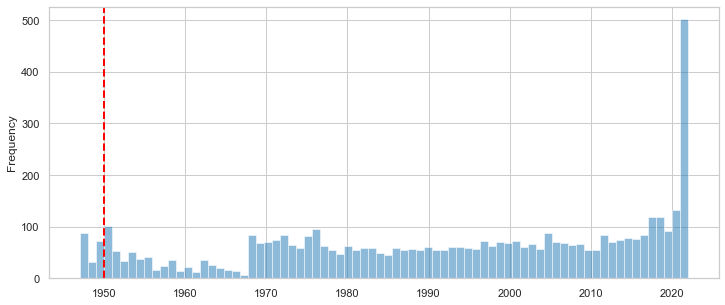

In [241]:
df_basic_info_clean['active_to'].plot.hist(bins=len(df_basic_info_clean['active_to'].unique()),alpha=0.5)

plt.axvline(x=1950,color='r',linestyle='--')

#df_basic_info_clean['active_from'].plot.hist(bins=(df_basic_info_clean['active_from'].max()-df_basic_info_clean['active_from'].min()),alpha=0.5)

In [242]:
df_complete_players = df_complete_players_raw.copy()

df_complete_players = df_complete_players.merge(df_basic_info_clean[['active_to','player_url']],on='player_url')
df_complete_players.head()

games_started_RegS  minutes_played_pg_RegS  field_goals_pg_RegS  \
0                53.0                    12.5                  2.4   
1                 NaN                    21.8                  3.5   
2               625.0                    36.8                 10.2   
3               336.0                    26.7                  6.0   
4               145.0                    20.4                  3.1   

   field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
0                           4.8                        0.502   
1                           8.2                        0.428   
2                          18.1                        0.559   
3                          13.6                        0.442   
4                           7.3                        0.417   

   _3pts_goals_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                  0.0                           0.0   
1                  NaN                           NaN   
2                  0.0                           0.0   
3                  0.8                           2.3   
4                  0.1                           0.3   

   _3pts_goals_percent_pg_RegS  _2pts_goals_pg_RegS  \
0                        0.000                  2.4   
1                          NaN                  NaN   
2                        0.056                 10.2   
3                        0.354                  5.2   
4                        0.237                  3.0   

   _2pts_goals_attempts_pg_RegS  ...  usage_percent  off_win_share  \
0                           4.8  ...            NaN            NaN   
1                           NaN  ...            NaN            NaN   
2                          18.1  ...            NaN            NaN   
3                          11.3  ...            NaN            NaN   
4                           7.0  ...            NaN            NaN   

   def_win_share  win_share  win_share_40min  off_box_pm  def_box_pm  box_pm  \
0            NaN        NaN              NaN         NaN         NaN     NaN   
1            NaN        NaN              NaN         NaN         NaN     NaN   
2            NaN        NaN              NaN         NaN         NaN     NaN   
3            NaN        NaN              NaN         NaN         NaN     NaN   
4            NaN        NaN              NaN         NaN         NaN     NaN   

                  player_url  active_to  
0  /players/a/abdelal01.html       1995  
1  /players/a/abdulza01.html       1978  
2  /players/a/abdulka01.html       1989  
3  /players/a/abdulma02.html       2001  
4  /players/a/abdulta01.html       2003  

[5 rows x 215 columns]

In [243]:
df_complete_players_1 = df_complete_players.copy()

df_complete_players_1 = df_complete_players_1[df_complete_players_1['active_to']>1950]
print("We've erased " + str(len(df_complete_players[df_complete_players['active_to']<=1950])) + ' players (only BAA players).')

columns_to_drop = ['active_to'] #investigar si más..., solo para la decisión del cleaning, porque al final sirve para el merge y tener en cuenta que añadiremos muchas más columnas!!!
df_complete_players_1 = df_complete_players_1.drop(columns_to_drop,axis=1)

We've erased 292 players (only BAA players).


In [244]:
df_complete_players_1

games_started_RegS  minutes_played_pg_RegS  field_goals_pg_RegS  \
0                   53.0                    12.5                  2.4   
1                    NaN                    21.8                  3.5   
2                  625.0                    36.8                 10.2   
3                  336.0                    26.7                  6.0   
4                  145.0                    20.4                  3.1   
...                  ...                     ...                  ...   
4979                30.0                    17.0                  1.7   
4980                27.0                    13.4                  2.4   
4981                 0.0                     4.3                  0.1   
4982                 NaN                     7.5                  0.9   
4983               185.0                    18.4                  3.2   

      field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
0                              4.8                        0.502   
1                              8.2                        0.428   
2                             18.1                        0.559   
3                             13.6                        0.442   
4                              7.3                        0.417   
...                            ...                          ...   
4979                           4.6                        0.371   
4980                           4.2                        0.581   
4981                           0.7                        0.200   
4982                           2.5                        0.363   
4983                           5.4                        0.596   

      _3pts_goals_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                     0.0                           0.0   
1                     NaN                           NaN   
2                     0.0                           0.0   
3                     0.8                           2.3   
4                     0.1                           0.3   
...                   ...                           ...   
4979                  0.7                           2.1   
4980                  0.0                           0.0   
4981                  0.0                           0.0   
4982                  NaN                           NaN   
4983                  0.0                           0.0   

      _3pts_goals_percent_pg_RegS  _2pts_goals_pg_RegS  \
0                           0.000                  2.4   
1                             NaN                  NaN   
2                           0.056                 10.2   
3                           0.354                  5.2   
4                           0.237                  3.0   
...                           ...                  ...   
4979                        0.335                  1.0   
4980                          NaN                  2.4   
4981                          NaN                  0.1   
4982                          NaN                  NaN   
4983                        0.100                  3.2   

      _2pts_goals_attempts_pg_RegS  ...  turnover_percent  usage_percent  \
0                              4.8  ...               NaN            NaN   
1                              NaN  ...               NaN            NaN   
2                             18.1  ...               NaN            NaN   
3                             11.3  ...              12.6            NaN   
4                              7.0  ...               NaN            NaN   
...                            ...  ...               ...            ...   
4979                           2.5  ...               NaN            NaN   
4980                           4.2  ...               NaN            NaN   
4981                           0.7  ...               NaN            NaN   
4982                           NaN  ...               NaN            NaN   
4983                           5.3  ...               NaN            NaN   

     

Now, we'll study a subset of players to decide initially which columns we may drop in order to reduce the dimensionality problem of this dataset, emembering our main aim: XXXXXXXXX

In [245]:
df_complete_players_subset = df_complete_players_1.sample(frac=0.1)
df_complete_players_subset

games_started_RegS  minutes_played_pg_RegS  field_goals_pg_RegS  \
2231               623.0                    34.1                  6.1   
1020                 2.0                     8.6                  1.1   
4295                24.0                     9.5                  0.8   
3229                79.0                    15.8                  2.2   
643                266.0                    21.3                  2.8   
...                  ...                     ...                  ...   
4780                 NaN                    28.0                  4.0   
1187                55.0                    19.2                  3.0   
526                183.0                    20.8                  3.5   
1407                95.0                    12.2                  1.6   
4663                 NaN                    21.4                  3.8   

      field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
2231                          12.5                        0.493   
1020                           2.7                        0.402   
4295                           1.7                        0.446   
3229                           4.9                        0.452   
643                            7.0                        0.403   
...                            ...                          ...   
4780                           8.5                        0.467   
1187                           6.4                        0.467   
526                            8.5                        0.413   
1407                           3.6                        0.440   
4663                           8.3                        0.455   

      _3pts_goals_pg_RegS  _3pts_goals_attempts_pg_RegS  \
2231                  0.2                           0.7   
1020                  0.0                           0.0   
4295                  0.0                           0.0   
3229                  0.6                           1.7   
643                   1.1                           3.1   
...                   ...                           ...   
4780                  0.0                           0.1   
1187                  0.4                           1.3   
526                   1.3                           3.4   
1407                  0.0                           0.1   
4663                  0.0                           0.0   

      _3pts_goals_percent_pg_RegS  _2pts_goals_pg_RegS  \
2231                        0.305                  5.9   
1020                        0.000                  1.1   
4295                        0.000                  0.8   
3229                        0.371                  1.6   
643                         0.362                  1.7   
...                           ...                  ...   
4780                        0.291                  3.9   
1187                        0.339                  2.7   
526                         0.370                  2.2   
1407                        0.225                  1.6   
4663                          NaN                  3.8   

      _2pts_goals_attempts_pg_RegS  ...  turnover_percent  usage_percent  \
2231                          11.7  ...              17.3            NaN   
1020                           2.7  ...               NaN            NaN   
4295                           1.7  ...               NaN            NaN   
3229                           3.2  ...               NaN            NaN   
643                            3.9  ...               NaN            NaN   
...                            ...  ...               ...            ...   
4780                           8.4  ...               NaN            NaN   
1187                           5.5  ...               NaN            NaN   
526                            5.1  ...              18.5           23.2   
1407                           3.5  ...              16.8            NaN   
4663                           8.3  ...               NaN            NaN   

     

We'll study also by subsetting the total number of columns depending on the info scrapped

In [246]:
Pg_RegS_df  = df_complete_players_subset.iloc[: , :24] #only includes Pg_RegS columns
Pg_Playoff_df  = df_complete_players_subset.iloc[: , 24:48]
Total_RegS_df  = df_complete_players_subset.iloc[: , 48:74]
Total_Playoff_df  = df_complete_players_subset.iloc[: , 74:100]
Advanced_RegS_df = df_complete_players_subset.iloc[: , 100:119]
Advanced_Playoff_df = df_complete_players_subset.iloc[: , 119:138]
Other_features_df = df_complete_players_subset.iloc[:,138:145]

# Las del college yo directamente me quedaría con a qué college han ido, porque un % elevado no ha ido y puede aportar ruido

# first_XXX_column  = df_complete_players_subset.iloc[: , 53:79]
# first_XXXX_column  = df_complete_players_subset.iloc[: , 80:106]
# first_XXXXX_column  = df_complete_players_subset.iloc[: , 107:126]

In [247]:
Pg_RegS_df.columns

Index(['games_started_RegS', 'minutes_played_pg_RegS', 'field_goals_pg_RegS',
       'field_goals_attempts_pg_RegS', 'field_goals_percent_pg_RegS',
       '_3pts_goals_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       '_3pts_goals_percent_pg_RegS', '_2pts_goals_pg_RegS',
       '_2pts_goals_attempts_pg_RegS', '_2pts_goals_percent_pg_RegS',
       'effective_field_goals_percent_pg_RegS', 'FT_goals_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'off_rebounds_pg_RegS', 'def_rebounds_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'steals_pg_RegS',
       'blocks_pg_RegS', 'turnovers_pg_RegS', 'personal_foults_pg_RegS',
       'points_pg_RegS'],
      dtype='object')

In [248]:
Pg_RegS_df.dtypes #nothing strange, because there may besome NaN in all columns

games_started_RegS                       float64
minutes_played_pg_RegS                   float64
field_goals_pg_RegS                      float64
field_goals_attempts_pg_RegS             float64
field_goals_percent_pg_RegS              float64
_3pts_goals_pg_RegS                      float64
_3pts_goals_attempts_pg_RegS             float64
_3pts_goals_percent_pg_RegS              float64
_2pts_goals_pg_RegS                      float64
_2pts_goals_attempts_pg_RegS             float64
_2pts_goals_percent_pg_RegS              float64
effective_field_goals_percent_pg_RegS    float64
FT_goals_pg_RegS                         float64
FT_goals_attempts_pg_RegS                float64
FT_goals_percent_pg_RegS                 float64
off_rebounds_pg_RegS                     float64
def_rebounds_pg_RegS                     float64
total_rebounds_pg_RegS                   float64
assists_pg_RegS                          float64
steals_pg_RegS                           float64
blocks_pg_RegS      

In [249]:
#profile_players_pg_RegS = Pg_RegS_df.profile_report()
#profile_players_pg_RegS.to_file("Reports/Raw_data/report_players_pg_RegS_raw_(subset).html")

#### player_info_per_game (RegS)
- games_started: Observamos que hay algunos con GS 0 o vacío, se entiende que los vacíos se pueden rellenar con 0's.
- minutes_played: maybe we could infer in it with KNN (low % of nullity), mira si es pot amb el dendogram omplir segons unes x variables.
- fg: we will choose attemps or total (similar distribution) + pct
- 3pts: 20% de missing, aquí no té molt sentit omplir. Alomillor un -1, per dir que no tenien linia de 3, imputar o crear una variable nova que ho tingui en compte!!!! (3p goals > 40% dels tirs totals).
- 2pts: la descarto -> per correlació amb fg_% -> fer gràfic.
- effective_pct: la descrato per correlacio amb fg i que hi ha masses Nan's-> fer gràfic
- els rebounds: tenim un 20% de missing als off i deff, per això, ens quedem amb els totals, i els que siguin missing posem un -1 perquè no es recollia la estadística o bé KNN amb alçada...
- assists: ok
- steals: hi ha missing (20%) que podem posar amb -1, tot i que es una dada que podem arribar a treure. Em quedo amb aquesta pq es la que té menys correlació....
- blocks: hi ha missing (20%) que podem posar amb -1, tot i que es una dada que podem arribar a treure.
- turnovers: hi ha missing (20%) que podem posar amb -1, tot i que es una dada que podem arribar a treure.
- pf: ok
- points: ok

In [250]:
pg_RegS_cols_to_drop = ['field_goals_pg_RegS','_3pts_goals_pg_RegS','_3pts_goals_percent_pg_RegS','_2pts_goals_pg_RegS', 
                        '_2pts_goals_attempts_pg_RegS','_2pts_goals_percent_pg_RegS','effective_field_goals_percent_pg_RegS',
                       'FT_goals_pg_RegS','off_rebounds_pg_RegS','def_rebounds_pg_RegS','blocks_pg_RegS','turnovers_pg_RegS'] #ver si hacen falta más

In [251]:
Pg_Playoff_df.columns

Index(['games_started_Playoff', 'minutes_played_pg_Playoff',
       'field_goals_pg_Playoff', 'field_goals_attempts_pg_Playoff',
       'field_goals_percent_pg_Playoff', '_3pts_goals_pg_Playoff',
       '_3pts_goals_attempts_pg_Playoff', '_3pts_goals_percent_pg_Playoff',
       '_2pts_goals_pg_Playoff', '_2pts_goals_attempts_pg_Playoff',
       '_2pts_goals_percent_pg_Playoff',
       'effective_field_goals_percent_pg_Playoff', 'FT_goals_pg_Playoff',
       'FT_goals_attempts_pg_Playoff', 'FT_goals_percent_pg_Playoff',
       'off_rebounds_pg_Playoff', 'def_rebounds_pg_Playoff',
       'total_rebounds_pg_Playoff', 'assists_pg_Playoff', 'steals_pg_Playoff',
       'blocks_pg_Playoff', 'turnovers_pg_Playoff',
       'personal_foults_pg_Playoff', 'points_pg_Playoff'],
      dtype='object')

In [252]:
Pg_Playoff_df.dtypes

games_started_Playoff                       float64
minutes_played_pg_Playoff                   float64
field_goals_pg_Playoff                      float64
field_goals_attempts_pg_Playoff             float64
field_goals_percent_pg_Playoff              float64
_3pts_goals_pg_Playoff                      float64
_3pts_goals_attempts_pg_Playoff             float64
_3pts_goals_percent_pg_Playoff              float64
_2pts_goals_pg_Playoff                      float64
_2pts_goals_attempts_pg_Playoff             float64
_2pts_goals_percent_pg_Playoff              float64
effective_field_goals_percent_pg_Playoff    float64
FT_goals_pg_Playoff                         float64
FT_goals_attempts_pg_Playoff                float64
FT_goals_percent_pg_Playoff                 float64
off_rebounds_pg_Playoff                     float64
def_rebounds_pg_Playoff                     float64
total_rebounds_pg_Playoff                   float64
assists_pg_Playoff                          float64
steals_pg_Pl

In [253]:
#profile_players_pg_Playoff = Pg_Playoff_df.profile_report()
#profile_players_pg_Playoff.to_file("Reports/Raw_data/report_players_pg_Playoff_raw_(subset).html")

In [254]:
pg_Playoff_cols_to_drop = ['field_goals_pg_Playoff','_3pts_goals_pg_Playoff','_3pts_goals_percent_pg_Playoff','_2pts_goals_pg_Playoff', 
                        '_2pts_goals_attempts_pg_Playoff','_2pts_goals_percent_pg_Playoff','effective_field_goals_percent_pg_Playoff',
                       'FT_goals_pg_Playoff','off_rebounds_pg_Playoff','def_rebounds_pg_Playoff','blocks_pg_Playoff','turnovers_pg_Playoff'] #ver si hacen falta más

In [255]:
Total_RegS_df.columns

Index(['games_RegS', 'games_started_RegS.1', 'minutes_played_total_RegS',
       'field_goals_total_RegS', 'field_goals_attempts_total_RegS',
       'field_goals_percent_total_RegS', '_3pts_goals_total_RegS',
       '_3pts_goals_attempts_total_RegS', '_3pts_goals_percent_total_RegS',
       '_2pts_goals_total_RegS', '_2pts_goals_attempts_total_RegS',
       '_2pts_goals_percent_total_RegS',
       'effective_field_goals_percent_total_RegS', 'FT_goals_total_RegS',
       'FT_goals_attempts_total_RegS', 'FT_goals_percent_total_RegS',
       'off_rebounds_total_RegS', 'def_rebounds_total_RegS',
       'total_rebounds_total_RegS', 'assists_total_RegS', 'steals_total_RegS',
       'blocks_total_RegS', 'turnovers_total_RegS',
       'personal_foults_total_RegS', 'points_total_RegS',
       'triple_doubles_total_RegS'],
      dtype='object')

In [256]:
Total_RegS_df.dtypes

games_RegS                                    int64
games_started_RegS.1                        float64
minutes_played_total_RegS                   float64
field_goals_total_RegS                        int64
field_goals_attempts_total_RegS               int64
field_goals_percent_total_RegS              float64
_3pts_goals_total_RegS                      float64
_3pts_goals_attempts_total_RegS             float64
_3pts_goals_percent_total_RegS              float64
_2pts_goals_total_RegS                      float64
_2pts_goals_attempts_total_RegS             float64
_2pts_goals_percent_total_RegS              float64
effective_field_goals_percent_total_RegS    float64
FT_goals_total_RegS                           int64
FT_goals_attempts_total_RegS                  int64
FT_goals_percent_total_RegS                 float64
off_rebounds_total_RegS                     float64
def_rebounds_total_RegS                     float64
total_rebounds_total_RegS                   float64
assists_tota

In [257]:
#profile_players_Total_RegS = Total_RegS_df.profile_report()
#profile_players_Total_RegS.to_file("Reports/Raw_data/report_players_Total_RegS_raw_(subset).html")

In [258]:
total_RegS_cols_to_drop = ['games_started_RegS.1','field_goals_total_RegS','_3pts_goals_total_RegS','_3pts_goals_percent_total_RegS','_2pts_goals_total_RegS', 
                        '_2pts_goals_attempts_total_RegS','_2pts_goals_percent_total_RegS','effective_field_goals_percent_total_RegS',
                       'FT_goals_total_RegS','off_rebounds_total_RegS','def_rebounds_total_RegS','blocks_total_RegS','turnovers_total_RegS','triple_doubles_total_RegS'] #ver si hacen falta más

In [259]:
Total_Playoff_df.columns

Index(['games_Playoff', 'games_started_Playoff.1',
       'minutes_played_total_Playoff', 'field_goals_total_Playoff',
       'field_goals_attempts_total_Playoff',
       'field_goals_percent_total_Playoff', '_3pts_goals_total_Playoff',
       '_3pts_goals_attempts_total_Playoff',
       '_3pts_goals_percent_total_Playoff', '_2pts_goals_total_Playoff',
       '_2pts_goals_attempts_total_Playoff',
       '_2pts_goals_percent_total_Playoff',
       'effective_field_goals_percent_total_Playoff', 'FT_goals_total_Playoff',
       'FT_goals_attempts_total_Playoff', 'FT_goals_percent_total_Playoff',
       'off_rebounds_total_Playoff', 'def_rebounds_total_Playoff',
       'total_rebounds_total_Playoff', 'assists_total_Playoff',
       'steals_total_Playoff', 'blocks_total_Playoff',
       'turnovers_total_Playoff', 'personal_foults_total_Playoff',
       'points_total_Playoff', 'triple_doubles_total_Playoff'],
      dtype='object')

In [260]:
Total_Playoff_df.dtypes

games_Playoff                                  float64
games_started_Playoff.1                        float64
minutes_played_total_Playoff                   float64
field_goals_total_Playoff                      float64
field_goals_attempts_total_Playoff             float64
field_goals_percent_total_Playoff              float64
_3pts_goals_total_Playoff                      float64
_3pts_goals_attempts_total_Playoff             float64
_3pts_goals_percent_total_Playoff              float64
_2pts_goals_total_Playoff                      float64
_2pts_goals_attempts_total_Playoff             float64
_2pts_goals_percent_total_Playoff              float64
effective_field_goals_percent_total_Playoff    float64
FT_goals_total_Playoff                         float64
FT_goals_attempts_total_Playoff                float64
FT_goals_percent_total_Playoff                 float64
off_rebounds_total_Playoff                     float64
def_rebounds_total_Playoff                     float64
total_rebo

In [261]:
#profile_players_Total_Playoff = Total_Playoff_df.profile_report()
#profile_players_Total_Playoff.to_file("Reports/Raw_data/report_players_Total_Playoff_raw_(subset).html")

In [262]:
total_Playoff_cols_to_drop = ['games_started_Playoff.1','field_goals_total_Playoff','_3pts_goals_total_Playoff','_3pts_goals_percent_total_Playoff','_2pts_goals_total_Playoff', 
                        '_2pts_goals_attempts_total_Playoff','_2pts_goals_percent_total_Playoff','effective_field_goals_percent_total_Playoff',
                       'FT_goals_total_Playoff','off_rebounds_total_Playoff','def_rebounds_total_Playoff','blocks_total_Playoff','turnovers_total_Playoff','triple_doubles_total_Playoff'] #ver si hacen falta más

In [263]:
Advanced_RegS_df.columns

Index(['player_eff_rating_RegS', 'true_shooting_eff_RegS',
       '_3pts_attempts_rate_RegS', 'FT_attempts_rate_RegS',
       'off_rebounds_percent_RegS', 'def_rebounds_percent_RegS',
       'total_rebounds_percent_RegS', 'assists_percent_RegS',
       'steals_percent_RegS', 'blocks_percent_RegS', 'turnover_percent_RegS',
       'usage_percent_RegS', 'off_win_share_RegS', 'def_win_share_RegS',
       'win_share_RegS', 'win_share_48min_RegS', 'off_box_pm_RegS',
       'def_box_pm_RegS', 'value_over_replacement_RegS'],
      dtype='object')

In [264]:
Advanced_RegS_df.dtypes

player_eff_rating_RegS         float64
true_shooting_eff_RegS         float64
_3pts_attempts_rate_RegS       float64
FT_attempts_rate_RegS          float64
off_rebounds_percent_RegS      float64
def_rebounds_percent_RegS      float64
total_rebounds_percent_RegS    float64
assists_percent_RegS           float64
steals_percent_RegS            float64
blocks_percent_RegS            float64
turnover_percent_RegS          float64
usage_percent_RegS             float64
off_win_share_RegS             float64
def_win_share_RegS             float64
win_share_RegS                 float64
win_share_48min_RegS           float64
off_box_pm_RegS                float64
def_box_pm_RegS                float64
value_over_replacement_RegS    float64
dtype: object

In [265]:
#profile_players_Advanced_RegS = Advanced_RegS_df.profile_report()
#profile_players_Advanced_RegS.to_file("Reports/Raw_data/report_players_Advanced_RegS_raw_(subset).html")

In [266]:
advanced_RegS_cols_to_drop = ['_3pts_attempts_rate_RegS', 'FT_attempts_rate_RegS',
                              'off_rebounds_percent_RegS', 'def_rebounds_percent_RegS','total_rebounds_percent_RegS', 
                              'assists_percent_RegS','steals_percent_RegS', 'blocks_percent_RegS', 
                              'turnover_percent_RegS','win_share_48min_RegS', 'off_box_pm_RegS','def_box_pm_RegS', 
                              'value_over_replacement_RegS']

# 'player_eff_rating_RegS', 'true_shooting_eff_RegS','usage_percent_RegS', 'off_win_share_RegS', 'def_win_share_RegS',
#       'win_share_RegS', Lo quitamos porque hay un elevado % de missing o por info repetida. Podemos quedarnos con la 1a variable, correla bastante....

In [267]:
Advanced_Playoff_df.columns

Index(['player_eff_rating_Playoff', 'true_shooting_eff_Playoff',
       '_3pts_attempts_rate_Playoff', 'FT_attempts_rate_Playoff',
       'off_rebounds_percent_Playoff', 'def_rebounds_percent_Playoff',
       'total_rebounds_percent_Playoff', 'assists_percent_Playoff',
       'steals_percent_Playoff', 'blocks_percent_Playoff',
       'turnover_percent_Playoff', 'usage_percent_Playoff',
       'off_win_share_Playoff', 'def_win_share_Playoff', 'win_share_Playoff',
       'win_share_48min_Playoff', 'off_box_pm_Playoff', 'def_box_pm_Playoff',
       'value_over_replacement_Playoff'],
      dtype='object')

In [268]:
Advanced_Playoff_df.dtypes

player_eff_rating_Playoff         float64
true_shooting_eff_Playoff         float64
_3pts_attempts_rate_Playoff       float64
FT_attempts_rate_Playoff          float64
off_rebounds_percent_Playoff      float64
def_rebounds_percent_Playoff      float64
total_rebounds_percent_Playoff    float64
assists_percent_Playoff           float64
steals_percent_Playoff            float64
blocks_percent_Playoff            float64
turnover_percent_Playoff          float64
usage_percent_Playoff             float64
off_win_share_Playoff             float64
def_win_share_Playoff             float64
win_share_Playoff                 float64
win_share_48min_Playoff           float64
off_box_pm_Playoff                float64
def_box_pm_Playoff                float64
value_over_replacement_Playoff    float64
dtype: object

In [269]:
#profile_players_Advanced_Playoff = Advanced_Playoff_df.profile_report()
#profile_players_Advanced_Playoff.to_file("Reports/Raw_data/report_players_Advanced_Playoff_raw_(subset).html")

In [270]:
advanced_Playoff_cols_to_drop = ['_3pts_attempts_rate_Playoff', 'FT_attempts_rate_Playoff',
                              'off_rebounds_percent_Playoff', 'def_rebounds_percent_Playoff','total_rebounds_percent_Playoff', 
                              'assists_percent_Playoff','steals_percent_Playoff', 'blocks_percent_Playoff', 
                              'turnover_percent_Playoff','win_share_48min_Playoff', 'off_box_pm_Playoff','def_box_pm_Playoff', 
                              'value_over_replacement_Playoff']

In [271]:
Other_features_df.columns

Index(['Hall_Of_Fame', 'n_NBA_Champ', 'n_All_Star', 'college_url',
       'gone_to_college', 'n_teams', 'teams_years_dict'],
      dtype='object')

In [272]:
Other_features_df.dtypes

Hall_Of_Fame        object
n_NBA_Champ          int64
n_All_Star           int64
college_url         object
gone_to_college     object
n_teams              int64
teams_years_dict    object
dtype: object

In [273]:
#profile_other_features = Other_features_df.profile_report()
#profile_other_features.to_file("Reports/Raw_data/report_other_features_(subset).html")
#Observamos que hay jugadores con n_teams = 0 -> los borramos porque no hay ninguno relevante (All-Star, Champ,etc...)

3 coses concluides: borrar columnes, treure els de num_teams = 0, i borrar totes les columnes de college [146:213] (quedarnos amb la última columna!!!!). Un cop fet això, tornar a estudiar correlacions generals en 3-4 paquets, i així acabar de netejar de columnes!!!!

In [274]:
cols_to_drop = pg_RegS_cols_to_drop + pg_Playoff_cols_to_drop + total_RegS_cols_to_drop + total_Playoff_cols_to_drop + advanced_RegS_cols_to_drop + advanced_Playoff_cols_to_drop

In [275]:
print("We've decided to erase firstly " +  str(len(cols_to_drop)) + ' columns.')

We've decided to erase firstly 78 columns.


In [276]:
df_complete_players_2 = df_complete_players_1.copy()
df_complete_players_2.head()

games_started_RegS  minutes_played_pg_RegS  field_goals_pg_RegS  \
0                53.0                    12.5                  2.4   
1                 NaN                    21.8                  3.5   
2               625.0                    36.8                 10.2   
3               336.0                    26.7                  6.0   
4               145.0                    20.4                  3.1   

   field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
0                           4.8                        0.502   
1                           8.2                        0.428   
2                          18.1                        0.559   
3                          13.6                        0.442   
4                           7.3                        0.417   

   _3pts_goals_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                  0.0                           0.0   
1                  NaN                           NaN   
2                  0.0                           0.0   
3                  0.8                           2.3   
4                  0.1                           0.3   

   _3pts_goals_percent_pg_RegS  _2pts_goals_pg_RegS  \
0                        0.000                  2.4   
1                          NaN                  NaN   
2                        0.056                 10.2   
3                        0.354                  5.2   
4                        0.237                  3.0   

   _2pts_goals_attempts_pg_RegS  ...  turnover_percent  usage_percent  \
0                           4.8  ...               NaN            NaN   
1                           NaN  ...               NaN            NaN   
2                          18.1  ...               NaN            NaN   
3                          11.3  ...              12.6            NaN   
4                           7.0  ...               NaN            NaN   

   off_win_share  def_win_share  win_share  win_share_40min  off_box_pm  \
0            NaN            NaN        NaN              NaN         NaN   
1            NaN            NaN        NaN              NaN         NaN   
2            NaN            NaN        NaN              NaN         NaN   
3            NaN            NaN        NaN              NaN         NaN   
4            NaN            NaN        NaN              NaN         NaN   

   def_box_pm  box_pm                 player_url  
0         NaN     NaN  /players/a/abdelal01.html  
1         NaN     NaN  /players/a/abdulza01.html  
2         NaN     NaN  /players/a/abdulka01.html  
3         NaN     NaN  /players/a/abdulma02.html  
4         NaN     NaN  /players/a/abdulta01.html  

[5 rows x 214 columns]

In [277]:
df_complete_players_2 = df_complete_players_2[[c for c in df_complete_players_2.columns if c not in cols_to_drop]]

In [278]:
df_complete_players_2

games_started_RegS  minutes_played_pg_RegS  \
0                   53.0                    12.5   
1                    NaN                    21.8   
2                  625.0                    36.8   
3                  336.0                    26.7   
4                  145.0                    20.4   
...                  ...                     ...   
4979                30.0                    17.0   
4980                27.0                    13.4   
4981                 0.0                     4.3   
4982                 NaN                     7.5   
4983               185.0                    18.4   

      field_goals_attempts_pg_RegS  field_goals_percent_pg_RegS  \
0                              4.8                        0.502   
1                              8.2                        0.428   
2                             18.1                        0.559   
3                             13.6                        0.442   
4                              7.3                        0.417   
...                            ...                          ...   
4979                           4.6                        0.371   
4980                           4.2                        0.581   
4981                           0.7                        0.200   
4982                           2.5                        0.363   
4983                           5.4                        0.596   

      _3pts_goals_attempts_pg_RegS  FT_goals_attempts_pg_RegS  \
0                              0.0                        1.3   
1                              NaN                        2.8   
2                              0.0                        6.0   
3                              2.3                        2.0   
4                              0.3                        2.2   
...                            ...                        ...   
4979                           2.1                        0.7   
4980                           0.0                        1.6   
4981                           0.0                        0.0   
4982                           NaN                        0.7   
4983                           0.0                        2.1   

      FT_goals_percent_pg_RegS  total_rebounds_pg_RegS  assists_pg_RegS  \
0                        0.701                     3.3              0.3   
1                        0.728                     8.0              1.2   
2                        0.721                    11.2              3.6   
3                        0.905                     1.9              3.5   
4                        0.703                     3.3              1.1   
...                        ...                     ...              ...   
4979                     0.769                     2.6              0.8   
4980                     0.711                     3.9              0.6   
4981                       NaN                     1.1              0.1   
4982                     0.556                     0.9              1.4   
4983                     0.761                     6.2              1.0   

      steals_pg_RegS  ...  turnover_percent  usage_percent  off_win_share  \
0                0.3  ...               NaN            NaN            NaN   
1                0.6  ...               NaN            NaN            NaN   
2                0.9  ...               NaN            NaN            NaN   
3                0.8  ...              12.6            NaN            NaN   
4                0.8  ...               NaN            NaN            NaN   
...              ...  ...               ...            ...            ...   
4979             0.4  ...               NaN            NaN            NaN   
4980             0.2  ...               NaN            NaN            NaN   
4981             0.1  ...               NaN            NaN            NaN   
4982             NaN  ...               NaN            NaN            NaN   
4983             0.3  ...               NaN    

In [279]:
list_cols_to_drop_college = df_complete_players_1.iloc[:,145:213].columns
print('We also do not consider the college variables, due to the fact that the vast majority has not gone to college.\nThat represents ' + str(len(list_cols_to_drop_college)) + ' columns.')

We also do not consider the college variables, due to the fact that the vast majority has not gone to college.
That represents 68 columns.


In [280]:
df_complete_players_2 = df_complete_players_2[[c for c in df_complete_players_2.columns if c not in list_cols_to_drop_college]]

In [281]:
df_complete_players_2.head()

games_started_RegS  minutes_played_pg_RegS  field_goals_attempts_pg_RegS  \
0                53.0                    12.5                           4.8   
1                 NaN                    21.8                           8.2   
2               625.0                    36.8                          18.1   
3               336.0                    26.7                          13.6   
4               145.0                    20.4                           7.3   

   field_goals_percent_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                        0.502                           0.0   
1                        0.428                           NaN   
2                        0.559                           0.0   
3                        0.442                           2.3   
4                        0.417                           0.3   

   FT_goals_attempts_pg_RegS  FT_goals_percent_pg_RegS  \
0                        1.3                     0.701   
1                        2.8                     0.728   
2                        6.0                     0.721   
3                        2.0                     0.905   
4                        2.2                     0.703   

   total_rebounds_pg_RegS  assists_pg_RegS  steals_pg_RegS  ...  \
0                     3.3              0.3             0.3  ...   
1                     8.0              1.2             0.6  ...   
2                    11.2              3.6             0.9  ...   
3                     1.9              3.5             0.8  ...   
4                     3.3              1.1             0.8  ...   

   def_win_share_Playoff  win_share_Playoff  Hall_Of_Fame  n_NBA_Champ  \
0                    0.1               -0.2            No            0   
1                    0.1                0.5            No            0   
2                   13.7               35.6           Yes            6   
3                    0.0                0.2            No            0   
4                    0.1                0.4            No            0   

   n_All_Star                                        college_url  \
0           0                                                NaN   
1           0                                                NaN   
2          19  https://www.sports-reference.com/cbb/players/k...   
3           0  https://www.sports-reference.com/cbb/players/m...   
4           0                                                NaN   

   gone_to_college  n_teams  \
0               No        5   
1               No        6   
2              Yes        2   
3              Yes        3   
4               No        4   

                                    teams_years_dict  \
0  {'team_0': ['Portland Trail Blazers'], 'years_...   
1  {'team_0': ['Cincinnati Royals'], 'years_0': [...   
2  {'team_0': ['Milwaukee Bucks'], 'years_0': ['1...   
3  {'team_0': ['Denver Nuggets'], 'years_0': ['19...   
4  {'team_0': ['Sacramento Kings'], 'years_0': ['...   

                  player_url  
0  /players/a/abdelal01.html  
1  /players/a/abdulza01.html  
2  /players/a/abdulka01.html  
3  /players/a/abdulma02.html  
4  /players/a/abdulta01.html  

[5 rows x 68 columns]

## Ahora vendría un segundo estudio de correlaciones
A partir de matrius de correlació i printar algunes relacions entre variables, decidim simplificar la dimensionalitat del dataset, encara bastant elevada...

In [282]:
#Tiene sentido ir buscando primero correlaciones entre los subgrupos

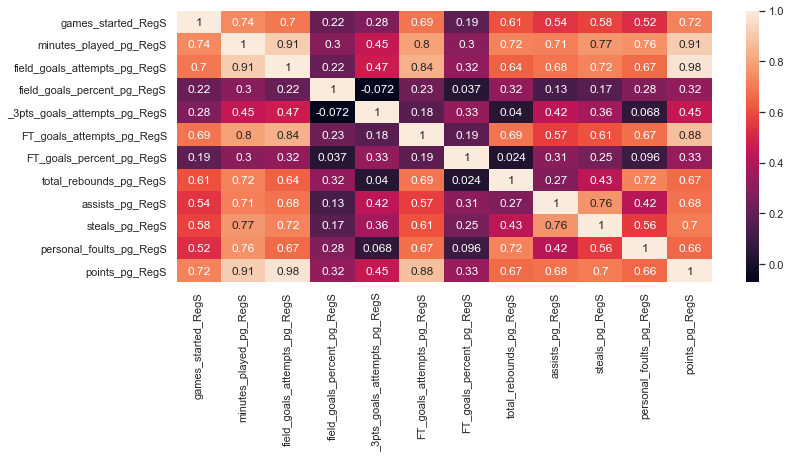

In [283]:
N = 12

RegS_pg_columns  = df_complete_players_2.iloc[: , :N]

corrMatrix = RegS_pg_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# It looks like there is a high correlation between: minutes played, field_goal_attemps and points

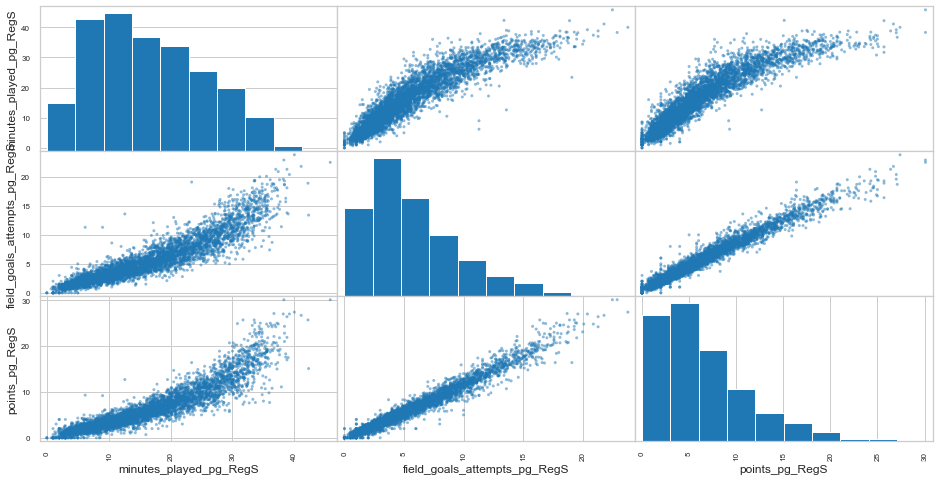

In [284]:
attributes = ['minutes_played_pg_RegS','field_goals_attempts_pg_RegS','points_pg_RegS']
scatter_matrix(df_complete_players_2[attributes], figsize=(16, 8))
plt.show()

Variance of each variable: 

minutes_played_pg_RegS          79.569897
field_goals_attempts_pg_RegS    15.054197
points_pg_RegS                  23.201357
dtype: float64


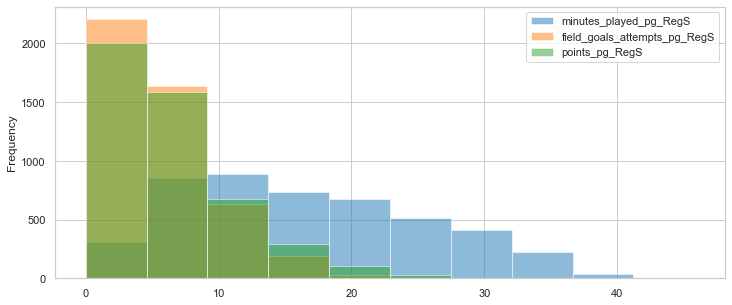

In [285]:
df_complete_players_2[attributes].plot.hist(alpha=0.5)
print('Variance of each variable: \n')
print(df_complete_players_2[attributes].var())
#so we select the field_goals.... and also points, that we'll delete later!!!!

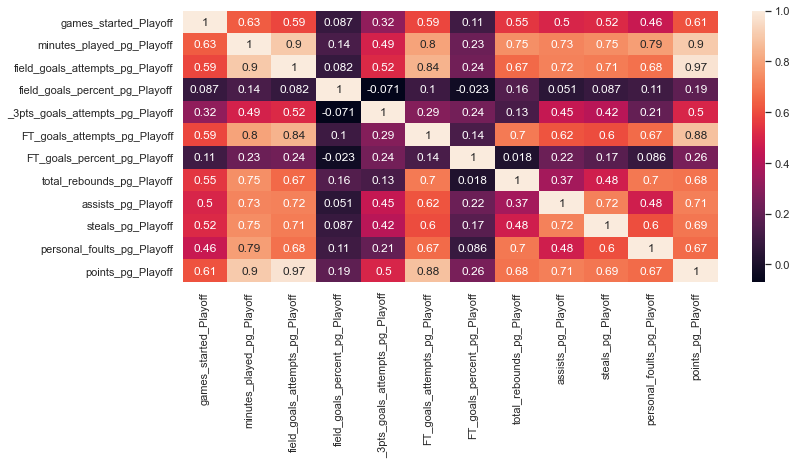

In [286]:
N = 12
M = 24

Playoff_pg_columns  = df_complete_players_2.iloc[: , N:M]

corrMatrix = Playoff_pg_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#Same as in RegS

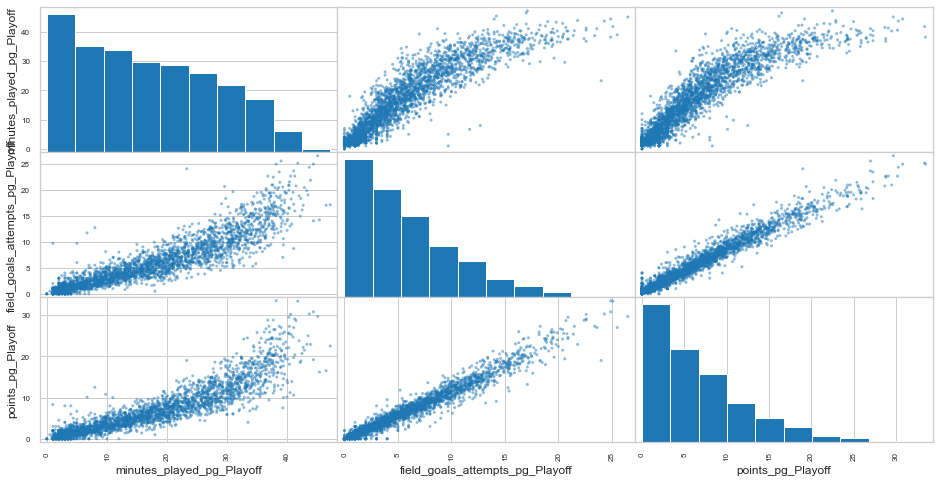

In [287]:
attributes = ['minutes_played_pg_Playoff','field_goals_attempts_pg_Playoff','points_pg_Playoff']
scatter_matrix(df_complete_players_2[attributes], figsize=(16, 8))
plt.show()

Variance of each variable: 

minutes_played_pg_Playoff          126.402616
field_goals_attempts_pg_Playoff     22.355291
points_pg_Playoff                   33.031433
dtype: float64


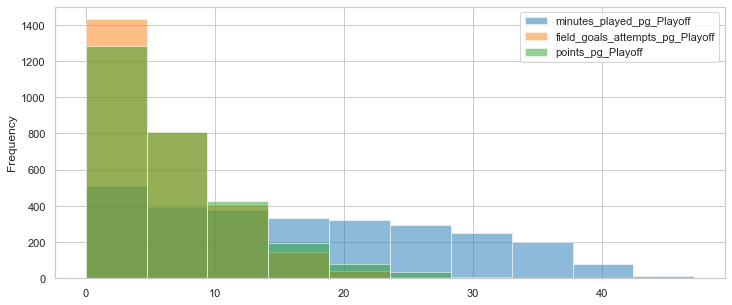

In [288]:
df_complete_players_2[attributes].plot.hist(alpha=0.5)
print('Variance of each variable: \n')
print(df_complete_players_2[attributes].var())
#so we select the field_goals.... and also points, that we'll delete later!!!!

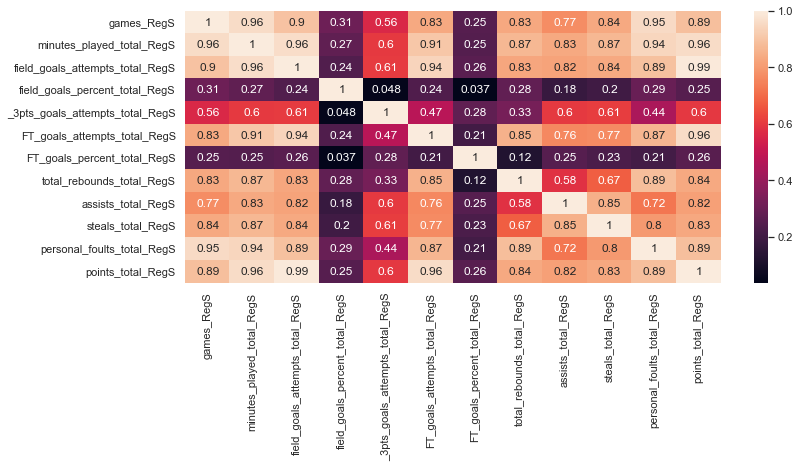

In [289]:
N = 24
M = 36

RegS_total_columns  = df_complete_players_2.iloc[: , N:M]

corrMatrix = RegS_total_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#Everything correlates a lot except 3 variables -> we'll only get those + assists_total_RegS and FT_goals_attempts_total_RegS

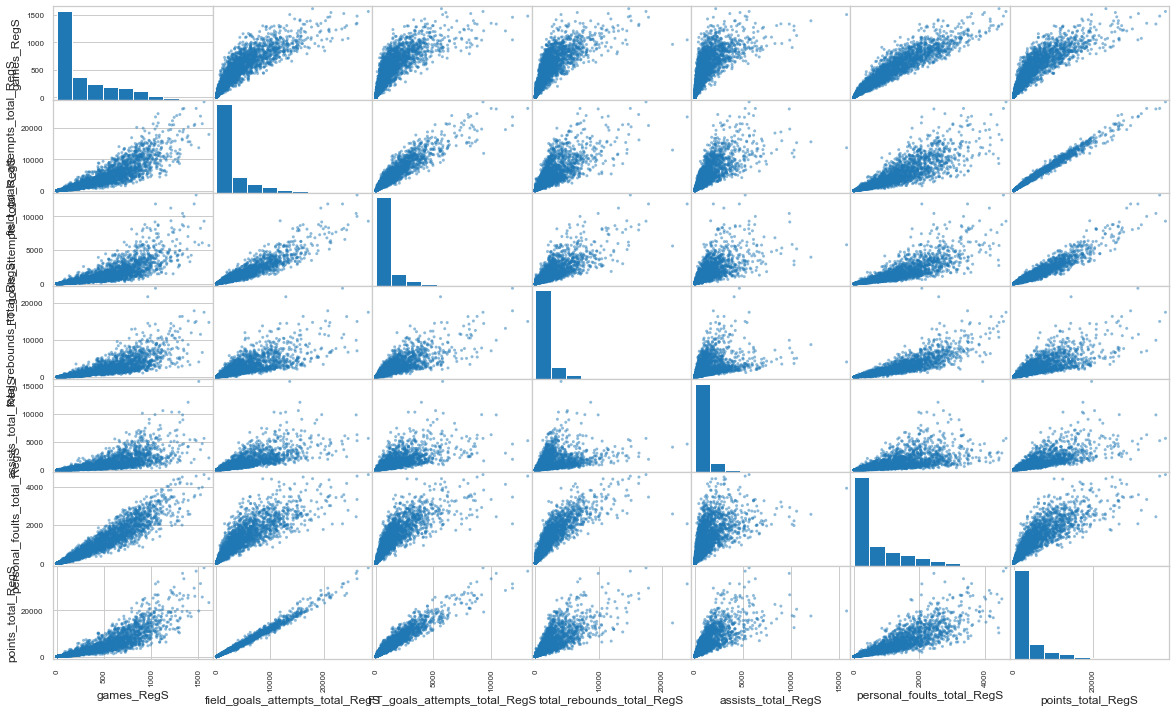

In [290]:
attributes = df_complete_players_2.iloc[: , 24:36].dropna(axis=1).columns
not_to_study = ['field_goals_percent_total_RegS','_3pts_goals_attempts_total_RegS','FT_goals_percent_total_RegS']

attributes = [c for c in attributes if c not in not_to_study]

scatter_matrix(df_complete_players_2[attributes], figsize=(20, 12)) #,diagonal='kde'
plt.show()

In [291]:
df_complete_players_2.iloc[: , 24:36].isna().sum() #That's why we can't for example consider the steals column..

games_RegS                           0
minutes_played_total_RegS           52
field_goals_attempts_total_RegS      0
field_goals_percent_total_RegS      26
_3pts_goals_attempts_total_RegS    836
FT_goals_attempts_total_RegS         0
FT_goals_percent_total_RegS        221
total_rebounds_total_RegS            0
assists_total_RegS                   0
steals_total_RegS                  905
personal_foults_total_RegS           0
points_total_RegS                    0
dtype: int64

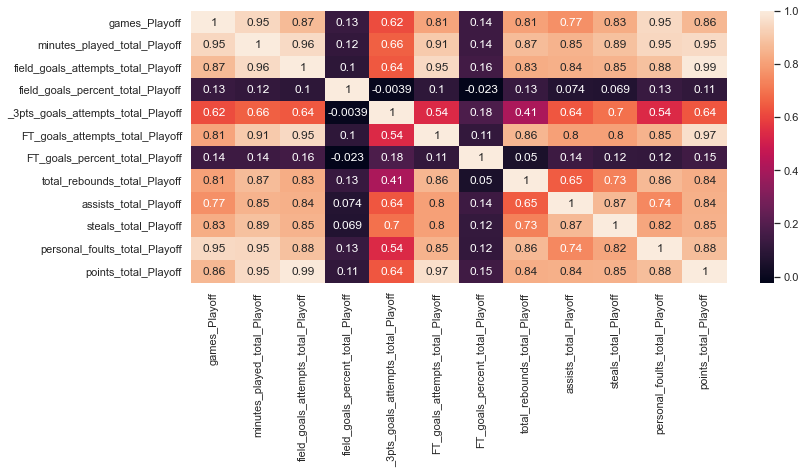

In [292]:
N = 36
M = 48

Playoff_total_columns  = df_complete_players_2.iloc[: , N:M]

corrMatrix = Playoff_total_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Same as the last one's

12


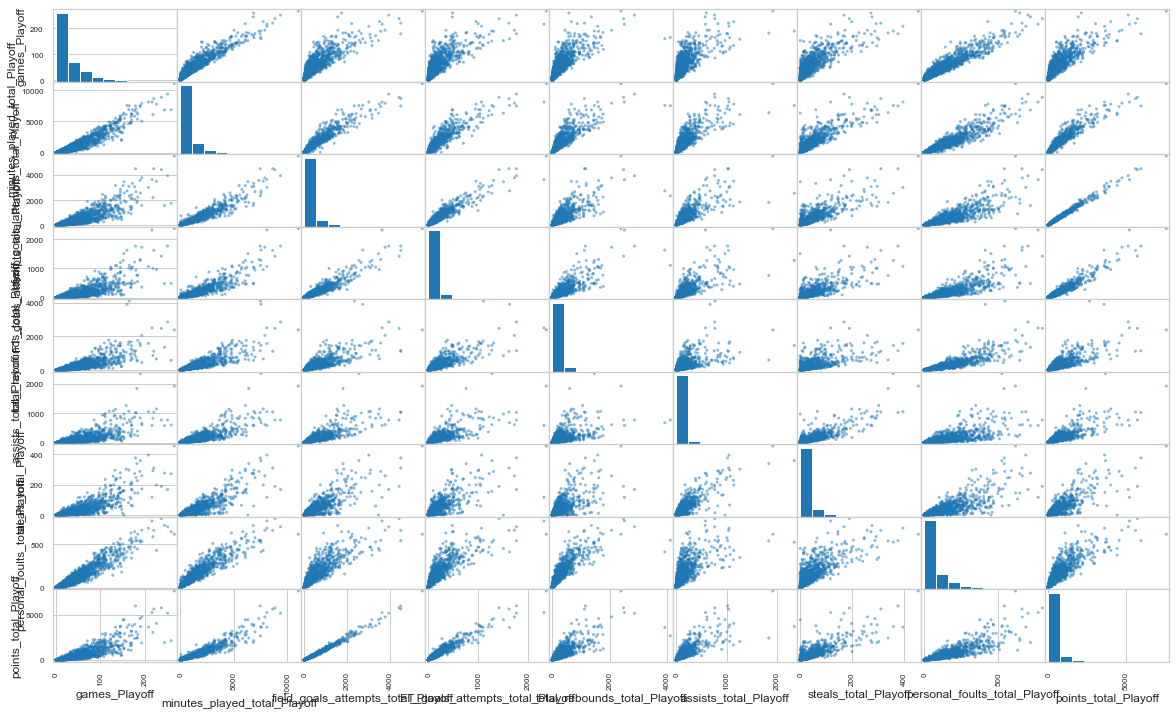

In [293]:
attributes = df_complete_players_2.iloc[: , 36:48].columns
print(len(attributes))
not_to_study = ['field_goals_percent_total_Playoff','_3pts_goals_attempts_total_Playoff','FT_goals_percent_total_Playoff']

attributes = [c for c in attributes if c not in not_to_study]

scatter_matrix(df_complete_players_2[attributes], figsize=(20, 12)) #,diagonal='kde'
plt.show()

In [294]:
df_complete_players_2.iloc[: , 36:48].isna().sum()

games_Playoff                         1857
minutes_played_total_Playoff          1913
field_goals_attempts_total_Playoff    1857
field_goals_percent_total_Playoff     1935
_3pts_goals_attempts_total_Playoff    2436
FT_goals_attempts_total_Playoff       1857
FT_goals_percent_total_Playoff        2233
total_rebounds_total_Playoff          1887
assists_total_Playoff                 1857
steals_total_Playoff                  2420
personal_foults_total_Playoff         1861
points_total_Playoff                  1857
dtype: int64

In [295]:
df_complete_players_2.iloc[: , 36:48].isna().sum()>1857 #number of players that have played playoffs

games_Playoff                         False
minutes_played_total_Playoff           True
field_goals_attempts_total_Playoff    False
field_goals_percent_total_Playoff      True
_3pts_goals_attempts_total_Playoff     True
FT_goals_attempts_total_Playoff       False
FT_goals_percent_total_Playoff         True
total_rebounds_total_Playoff           True
assists_total_Playoff                 False
steals_total_Playoff                   True
personal_foults_total_Playoff          True
points_total_Playoff                  False
dtype: bool

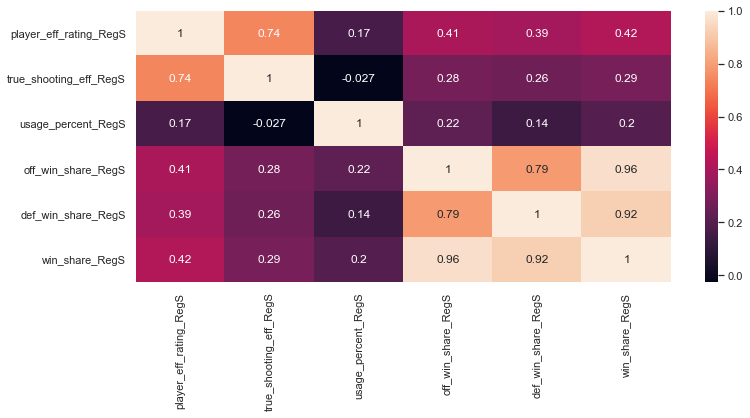

In [296]:
N = 48
M = 54

RegS_advanced_columns  = df_complete_players_2.iloc[: , N:M]

corrMatrix = RegS_advanced_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# nos quedamos con el win share ratting (+ fácil de entender), el resto ok

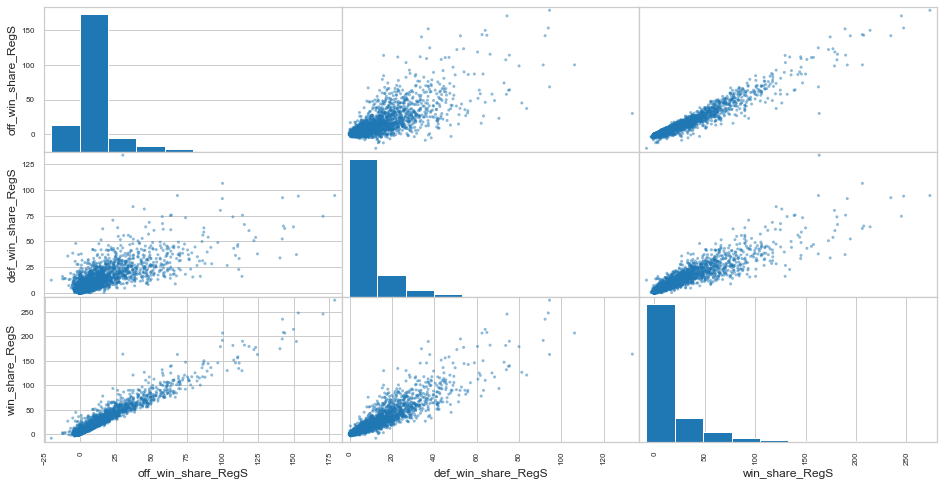

In [297]:
attributes = ['off_win_share_RegS','def_win_share_RegS','win_share_RegS']
scatter_matrix(df_complete_players_2[attributes], figsize=(16, 8))
plt.show()

Variance of each variable: 

off_win_share_RegS    277.728501
def_win_share_RegS    130.158242
win_share_RegS        708.149322
dtype: float64


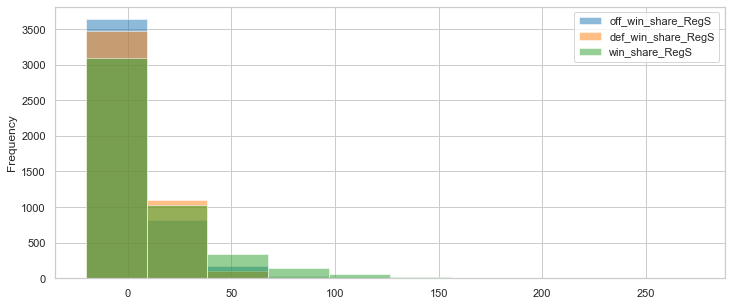

In [298]:
df_complete_players_2[attributes].plot.hist(alpha=0.5)
print('Variance of each variable: \n')
print(df_complete_players_2[attributes].var()) #although the high variance, with standard scaling we'll avoid the noise...

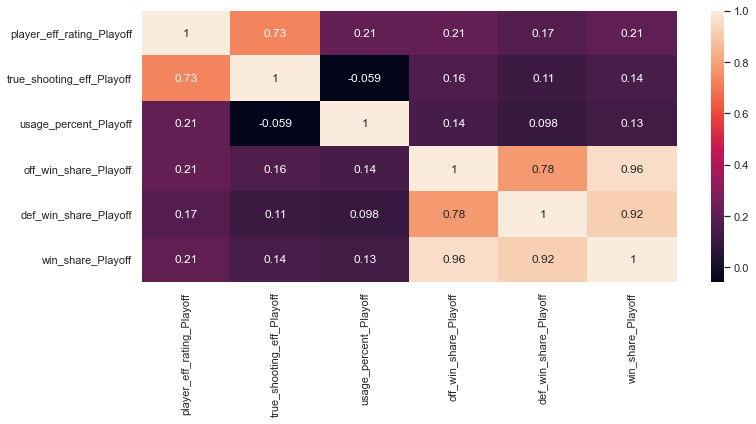

In [299]:
N = 54
M = 60

Playoff_advanced_columns  = df_complete_players_2.iloc[: , N:M]

corrMatrix = Playoff_advanced_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# More or less the same, and the correlations with the share make sense....

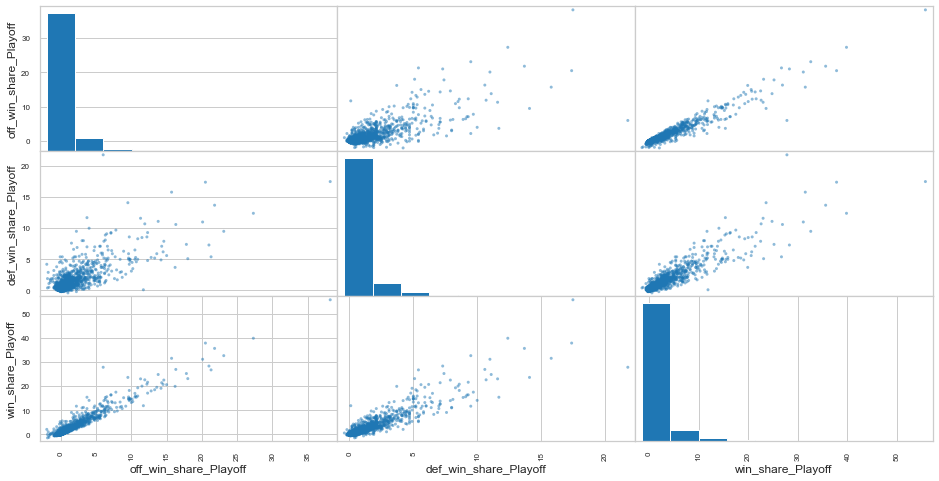

In [300]:
attributes = ['off_win_share_Playoff','def_win_share_Playoff','win_share_Playoff']
scatter_matrix(df_complete_players_2[attributes], figsize=(16, 8))
plt.show()

Variance of each variable: 

off_win_share_Playoff     5.335344
def_win_share_Playoff     2.564053
win_share_Playoff        13.672691
dtype: float64


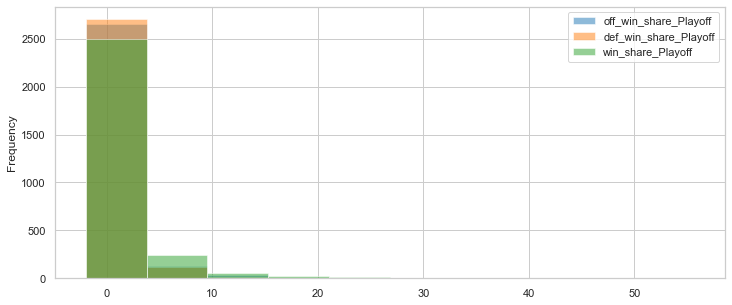

In [301]:
df_complete_players_2[attributes].plot.hist(alpha=0.5)
print('Variance of each variable: \n')
print(df_complete_players_2[attributes].var()) #although the high variance, with standard scaling we'll avoid the noise...

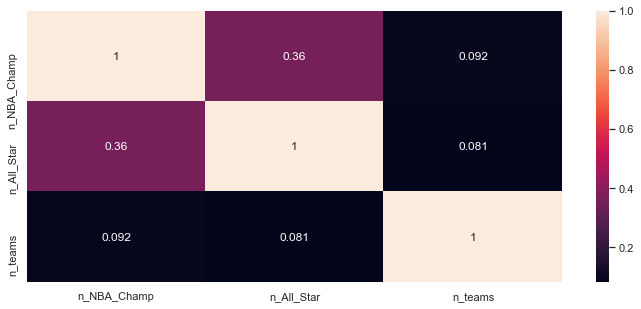

In [302]:
N = 60

Others  = df_complete_players_2.iloc[: , N:]

corrMatrix = Others.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# Everything ok

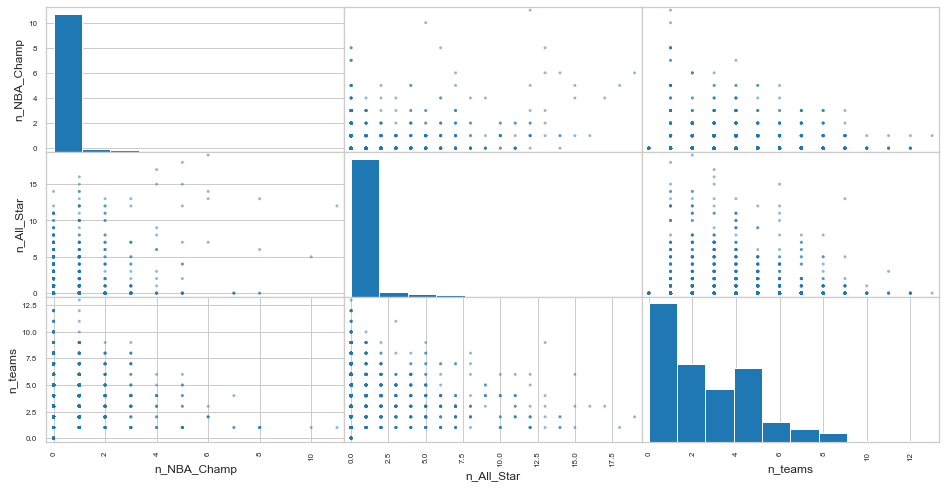

In [303]:
attributes = df_complete_players_2.iloc[: , 60:].columns
scatter_matrix(df_complete_players_2[attributes], figsize=(16, 8))
plt.show()#there's no correlation at all...

In [304]:
#Based on the correlation studies...
extra_cols_to_drop = ['minutes_played_pg_RegS','minutes_played_pg_Playoff'
                      ,'points_total_RegS','personal_foults_total_RegS','steals_total_RegS','total_rebounds_total_RegS'
                      ,'FT_goals_percent_total_RegS','_3pts_goals_attempts_total_RegS','field_goals_percent_total_RegS'
                      ,'field_goals_attempts_total_RegS','minutes_played_total_RegS','games_RegS'
                     ,'points_total_Playoff','personal_foults_total_Playoff','steals_total_Playoff','total_rebounds_total_Playoff'
                      ,'FT_goals_percent_total_Playoff','_3pts_goals_attempts_total_Playoff','field_goals_percent_total_Playoff'
                      ,'field_goals_attempts_total_Playoff','minutes_played_total_Playoff','games_Playoff',
                     'def_win_share_RegS','off_win_share_RegS','def_win_share_Playoff','off_win_share_Playoff']

In [305]:
df_complete_players_3 = df_complete_players_2.copy()
df_complete_players_3 = df_complete_players_3[[c for c in df_complete_players_3.columns if c not in extra_cols_to_drop]]

In [306]:
df_complete_players_3.head()

games_started_RegS  field_goals_attempts_pg_RegS  \
0                53.0                           4.8   
1                 NaN                           8.2   
2               625.0                          18.1   
3               336.0                          13.6   
4               145.0                           7.3   

   field_goals_percent_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                        0.502                           0.0   
1                        0.428                           NaN   
2                        0.559                           0.0   
3                        0.442                           2.3   
4                        0.417                           0.3   

   FT_goals_attempts_pg_RegS  FT_goals_percent_pg_RegS  \
0                        1.3                     0.701   
1                        2.8                     0.728   
2                        6.0                     0.721   
3                        2.0                     0.905   
4                        2.2                     0.703   

   total_rebounds_pg_RegS  assists_pg_RegS  steals_pg_RegS  \
0                     3.3              0.3             0.3   
1                     8.0              1.2             0.6   
2                    11.2              3.6             0.9   
3                     1.9              3.5             0.8   
4                     3.3              1.1             0.8   

   personal_foults_pg_RegS  ...  usage_percent_Playoff  win_share_Playoff  \
0                      1.9  ...                   22.1               -0.2   
1                      2.2  ...                    NaN                0.5   
2                      3.0  ...                   25.6               35.6   
3                      1.9  ...                   25.3                0.2   
4                      2.1  ...                   19.8                0.4   

   Hall_Of_Fame  n_NBA_Champ  n_All_Star  \
0            No            0           0   
1            No            0           0   
2           Yes            6          19   
3            No            0           0   
4            No            0           0   

                                         college_url  gone_to_college  \
0                                                NaN               No   
1                                                NaN               No   
2  https://www.sports-reference.com/cbb/players/k...              Yes   
3  https://www.sports-reference.com/cbb/players/m...              Yes   
4                                                NaN               No   

   n_teams                                   teams_years_dict  \
0        5  {'team_0': ['Portland Trail Blazers'], 'years_...   
1        6  {'team_0': ['Cincinnati Royals'], 'years_0': [...   
2        2  {'team_0': ['Milwaukee Bucks'], 'years_0': ['1...   
3        3  {'team_0': ['Denver Nuggets'], 'years_0': ['19...   
4        4  {'team_0': ['Sacramento Kings'], 'years_0': ['...   

                  player_url  
0  /players/a/abdelal01.html  
1  /players/a/abdulza01.html  
2  /players/a/abdulka01.html  
3  /players/a/abdulma02.html  
4  /players/a/abdulta01.html  

[5 rows x 42 columns]

In [307]:
df_complete_players_3.columns

Index(['games_started_RegS', 'field_goals_attempts_pg_RegS',
       'field_goals_percent_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'steals_pg_RegS',
       'personal_foults_pg_RegS', 'points_pg_RegS', 'games_started_Playoff',
       'field_goals_attempts_pg_Playoff', 'field_goals_percent_pg_Playoff',
       '_3pts_goals_attempts_pg_Playoff', 'FT_goals_attempts_pg_Playoff',
       'FT_goals_percent_pg_Playoff', 'total_rebounds_pg_Playoff',
       'assists_pg_Playoff', 'steals_pg_Playoff', 'personal_foults_pg_Playoff',
       'points_pg_Playoff', 'FT_goals_attempts_total_RegS',
       'assists_total_RegS', 'FT_goals_attempts_total_Playoff',
       'assists_total_Playoff', 'player_eff_rating_RegS',
       'true_shooting_eff_RegS', 'usage_percent_RegS', 'win_share_RegS',
       'player_eff_rating_Playoff', 'true_shooting_eff_Playoff',
       'usage_percent_Playoff', 'win_shar

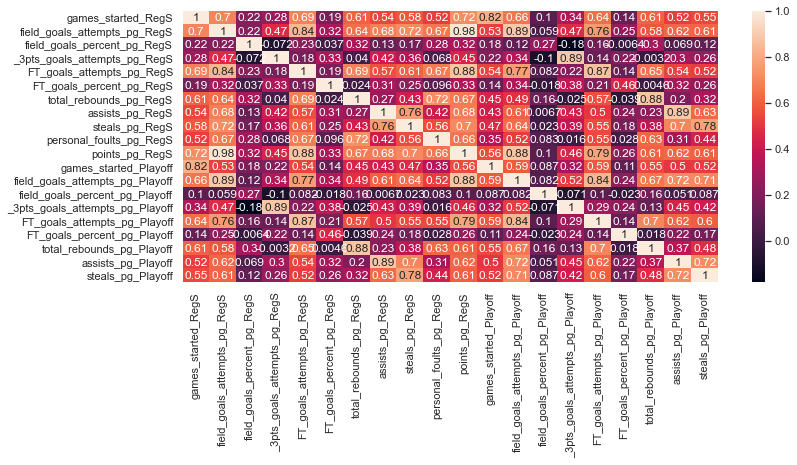

In [308]:
N = 0
M = 20

RegS_total_columns  = df_complete_players_3.iloc[: , N:M]

corrMatrix = RegS_total_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

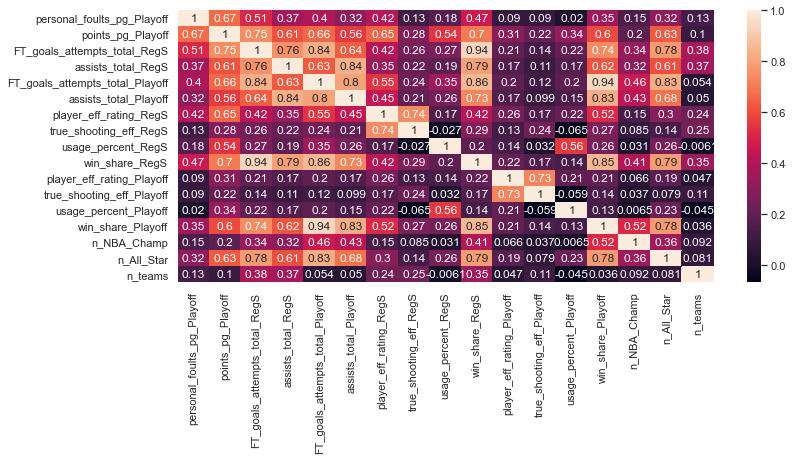

In [309]:
N = 20
M = len(df_complete_players_3)

RegS_total_columns  = df_complete_players_3.iloc[: , N:M]

corrMatrix = RegS_total_columns.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
#There is a high correlation berween Platoff and RegS variables, wich is normal, but we need to consider them in orther to lcuster the playoff players correctly....

In [310]:
df_complete_players_3.iloc[: , 0:20].describe()

games_started_RegS  field_goals_attempts_pg_RegS  \
count         3276.000000                   4693.000000   
mean           139.296093                      5.767270   
std            234.360731                      3.879974   
min              0.000000                      0.000000   
25%              0.000000                      2.800000   
50%             21.000000                      4.800000   
75%            172.000000                      7.900000   
max           1471.000000                     23.800000   

       field_goals_percent_pg_RegS  _3pts_goals_attempts_pg_RegS  \
count                  4667.000000                   3857.000000   
mean                      0.417305                      0.998107   
std                       0.102460                      1.340633   
min                       0.000000                      0.000000   
25%                       0.379000                      0.000000   
50%                       0.429000                      0.400000   
75%                       0.468000                      1.600000   
max                       1.000000                      8.800000   

       FT_goals_attempts_pg_RegS  FT_goals_percent_pg_RegS  \
count                4693.000000               4472.000000   
mean                    1.753228                  0.703523   
std                     1.437451                  0.138474   
min                     0.000000                  0.000000   
25%                     0.800000                  0.640000   
50%                     1.400000                  0.724000   
75%                     2.400000                  0.786000   
max                    11.400000                  1.000000   

       total_rebounds_pg_RegS  assists_pg_RegS  steals_pg_RegS  \
count             4693.000000      4693.000000     3788.000000   
mean                 3.029065         1.444705        0.550818   
std                  2.297734         1.376505        0.397001   
min                  0.000000         0.000000        0.000000   
25%                  1.400000         0.500000        0.300000   
50%                  2.400000         1.000000        0.500000   
75%                  4.000000         2.000000        0.800000   
max                 22.900000        11.200000        2.700000   

       personal_foults_pg_RegS  points_pg_RegS  games_started_Playoff  \
count              4693.000000     4693.000000            1841.000000   
mean                  1.766503        6.521607              15.611081   
std                   0.848050        4.816779              30.610043   
min                   0.000000        0.000000               0.000000   
25%                   1.100000        2.900000               0.000000   
50%                   1.800000        5.300000               2.000000   
75%                   2.400000        8.900000              16.000000   
max                   5.000000       30.100000             266.000000   

       field_goals_attempts_pg_Playoff  field_goals_percent_pg_Playoff  \
count                      2836.000000                     2758.000000   
mean                          5.870910                        0.420483   
std                           4.728138                        0.153092   
min                           0.000000                        0.000000   
25%                           2.000000                        0.373250   
50%                           4.700000                        0.429000   
75%                           8.600000                        0.481000   
max                          26.500000                        1.000000   

       _3pts_goals_attempts_pg_Playoff  FT_goals_attempts_pg_Playoff  \
count                      2257.000000                   2836.000000   
mean                          1.054674                      1.897673   
std                           1.505718                      1.802458   
min                           0.000000                      0.000000   
25%                    

In [311]:
df_complete_players_3.iloc[: , 20:].describe()

personal_foults_pg_Playoff  points_pg_Playoff  \
count                 2832.000000        2836.000000   
mean                     1.891843           6.714986   
std                      1.151784           5.747298   
min                      0.000000           0.000000   
25%                      1.000000           2.200000   
50%                      1.900000           5.300000   
75%                      2.800000           9.700000   
max                      6.000000          33.500000   

       FT_goals_attempts_total_RegS  assists_total_RegS  \
count                   4693.000000         4693.000000   
mean                     771.246324          647.572129   
std                     1310.418850         1184.402275   
min                        0.000000            0.000000   
25%                       26.000000           17.000000   
50%                      193.000000          145.000000   
75%                      974.000000          736.000000   
max                    13188.000000        15806.000000   

       FT_goals_attempts_total_Playoff  assists_total_Playoff  \
count                      2836.000000            2836.000000   
mean                         89.980254              68.200635   
std                         182.379716             147.505641   
min                           0.000000               0.000000   
25%                           4.000000               2.000000   
50%                          24.000000              15.000000   
75%                          94.000000              70.000000   
max                        2364.000000            2346.000000   

       player_eff_rating_RegS  true_shooting_eff_RegS  usage_percent_RegS  \
count             4635.000000             4670.000000         3938.000000   
mean                11.227659                0.480221           18.690198   
std                  6.524589                0.103608            4.924496   
min                -52.700000                0.000000            0.000000   
25%                  9.000000                0.443000           15.600000   
50%                 11.700000                0.496000           18.400000   
75%                 14.200000                0.534000           21.400000   
max                 88.300000                1.500000           56.600000   

       win_share_RegS  player_eff_rating_Playoff  true_shooting_eff_Playoff  \
count     4691.000000                2776.000000                2765.000000   
mean        14.312130                  11.820209                   0.487482   
std         26.611075                  10.980546                   0.157890   
min         -7.900000                 -90.500000                   0.000000   
25%          0.100000                   8.700000                   0.440000   
50%          2.200000                  12.200000                   0.502000   
75%         17.250000                  15.300000                   0.548000   
max        273.400000                 122.400000                   1.500000   

       usage_percent_Playoff  win_share_Playoff  n_NBA_Champ  n_All_Star  \
count            2277.000000        2836.000000  4693.000000  4693.00000   
mean               18.577866           1.619429     0.197315     0.40912   
std                 7.216424           3.697660     0.697591     1.62452   
min                 0.000000          -1.400000     0.000000     0.00000   
25%                14.500000           0.000000     0.000000     0.00000   
50%                18.100000           0.300000     0.000000     0.00000   
75%                22.100000           1.600000     0.000000     0.00000   
max                72.800000          55.700000    11.000000    19.00000   

           n_teams  
count  4693.000000  
mean      2.774771  
std       1.985504  
min       0.000000  
25%       1.000000  
50%       2.000000  
75%       4.000000  
max      13.000000

In [312]:
#profile_cleaned = df_complete_players_3.profile_report()
#profile_cleaned.to_file("Reports/Raw_data/report_cleaned_(44 variables).html")

### Now we'll complete all the NaN values using the common sense....

In [313]:
# games_started_regS -> 0's (la mitad ok, la otra no, ya cuadra porque los equipos son de 12 jugadores...)
# field_goals_percent_pg_PegS -> 0's (coinciden con los attemps 0!!!!)
# 3pts_attempts_RegS_pg -> con -1 cuando no había linia... (estudiar por años!!!!)
# FT_goals_percent_pg_RegS -> 0's (coinciden con los attempts = 0)
# steals hi ha uns missings importants (ver si es un tema de años) -> ELIMINAR!
# Fer flag de playoff
    # contar los missings, en principio mismas normas que antes!!!!
    
# true_shooting, usage (darle - peso), off/deff_win_share tot completar amb KNN (estudiaria estas advanced por año!!!!)
# eliminar los que tienen dictionary de equipos = {}, porque juegan en equipos menores...

AxesSubplot(0.125,0.125;0.698618x0.755)
games_started_RegS                 0.301939
field_goals_attempts_pg_RegS       0.000000
field_goals_percent_pg_RegS        0.005540
_3pts_goals_attempts_pg_RegS       0.178138
FT_goals_attempts_pg_RegS          0.000000
FT_goals_percent_pg_RegS           0.047091
total_rebounds_pg_RegS             0.000000
assists_pg_RegS                    0.000000
steals_pg_RegS                     0.192840
personal_foults_pg_RegS            0.000000
points_pg_RegS                     0.000000
games_started_Playoff              0.607714
field_goals_attempts_pg_Playoff    0.395696
field_goals_percent_pg_Playoff     0.412316
_3pts_goals_attempts_pg_Playoff    0.519071
FT_goals_attempts_pg_Playoff       0.395696
FT_goals_percent_pg_Playoff        0.475815
total_rebounds_pg_Playoff          0.402088
assists_pg_Playoff                 0.395696
steals_pg_Playoff                  0.515662
personal_foults_pg_Playoff         0.396548
points_pg_Playoff                  0

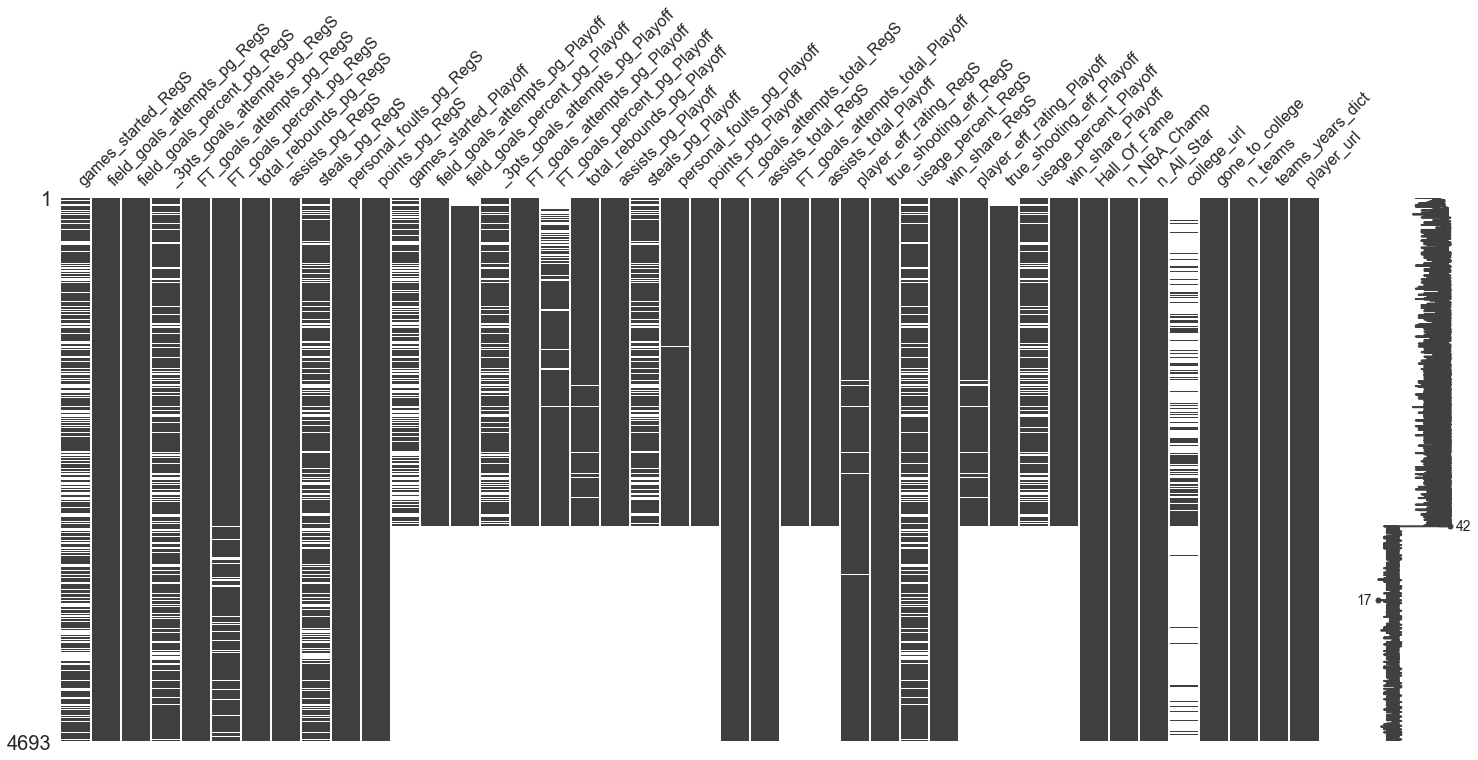

In [314]:
print(msno.matrix(df_complete_players_3.sort_values(by='field_goals_attempts_pg_Playoff')))
print(df_complete_players_3.isna().sum()/len(df_complete_players_3))

In [315]:
df_complete_players_3.columns[df_complete_players_3.isnull().any()]

Index(['games_started_RegS', 'field_goals_percent_pg_RegS',
       '_3pts_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'steals_pg_RegS', 'games_started_Playoff',
       'field_goals_attempts_pg_Playoff', 'field_goals_percent_pg_Playoff',
       '_3pts_goals_attempts_pg_Playoff', 'FT_goals_attempts_pg_Playoff',
       'FT_goals_percent_pg_Playoff', 'total_rebounds_pg_Playoff',
       'assists_pg_Playoff', 'steals_pg_Playoff', 'personal_foults_pg_Playoff',
       'points_pg_Playoff', 'FT_goals_attempts_total_Playoff',
       'assists_total_Playoff', 'player_eff_rating_RegS',
       'true_shooting_eff_RegS', 'usage_percent_RegS', 'win_share_RegS',
       'player_eff_rating_Playoff', 'true_shooting_eff_Playoff',
       'usage_percent_Playoff', 'win_share_Playoff', 'college_url'],
      dtype='object')

In [316]:
df_complete_players_4 = df_complete_players_3.copy()

fill_with_zeros = ['games_started_RegS','field_goals_percent_pg_RegS','FT_goals_percent_pg_RegS']
for i in fill_with_zeros:
    df_complete_players_4[i] = df_complete_players_4[i].fillna(0)

In [317]:
#msno.matrix(df_complete_players_4.sort_values(by='field_goals_attempts_pg_Playoff'))

In [318]:
fill_with_minus_1 = ['_3pts_goals_attempts_pg_RegS']
for i in fill_with_minus_1:
    df_complete_players_4[i] = df_complete_players_4[i].fillna(-1)

In [319]:
df_complete_players_4['Playoff_flag'] = df_complete_players_4.apply(lambda x: 'Yes' if x['field_goals_attempts_pg_Playoff']>=0 else 'No',axis=1)

In [320]:
df_complete_players_4['Playoff_flag'].value_counts()

Yes    2836
No     1857
Name: Playoff_flag, dtype: int64

In [321]:
fill_with_zeros_Playoff = ['games_started_Playoff','field_goals_percent_pg_Playoff','FT_goals_percent_pg_Playoff','personal_foults_pg_Playoff','total_rebounds_pg_Playoff']
for i in fill_with_zeros_Playoff:
    df_complete_players_4.loc[df_complete_players_4[(df_complete_players_4[i].isna()) & (df_complete_players_4['Playoff_flag']=='Yes')].index,i] = 0

In [322]:
fill_with_minus_1_Playoff = ['_3pts_goals_attempts_pg_Playoff']
for i in fill_with_minus_1_Playoff:
    df_complete_players_4.loc[df_complete_players_4[(df_complete_players_4[i].isna()) & (df_complete_players_4['Playoff_flag']=='Yes')].index,i] = -1

In [323]:
#primer merge con el original !!!!steals hacer gràfic con año!!!

In [324]:
testing_merge = df_complete_players_4.merge(df_basic_info_clean[['player_url','active_from']],on='player_url')

In [325]:
testing_merge.head()

games_started_RegS  field_goals_attempts_pg_RegS  \
0                53.0                           4.8   
1                 0.0                           8.2   
2               625.0                          18.1   
3               336.0                          13.6   
4               145.0                           7.3   

   field_goals_percent_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                        0.502                           0.0   
1                        0.428                          -1.0   
2                        0.559                           0.0   
3                        0.442                           2.3   
4                        0.417                           0.3   

   FT_goals_attempts_pg_RegS  FT_goals_percent_pg_RegS  \
0                        1.3                     0.701   
1                        2.8                     0.728   
2                        6.0                     0.721   
3                        2.0                     0.905   
4                        2.2                     0.703   

   total_rebounds_pg_RegS  assists_pg_RegS  steals_pg_RegS  \
0                     3.3              0.3             0.3   
1                     8.0              1.2             0.6   
2                    11.2              3.6             0.9   
3                     1.9              3.5             0.8   
4                     3.3              1.1             0.8   

   personal_foults_pg_RegS  ...  Hall_Of_Fame  n_NBA_Champ  n_All_Star  \
0                      1.9  ...            No            0           0   
1                      2.2  ...            No            0           0   
2                      3.0  ...           Yes            6          19   
3                      1.9  ...            No            0           0   
4                      2.1  ...            No            0           0   

                                         college_url  gone_to_college  \
0                                                NaN               No   
1                                                NaN               No   
2  https://www.sports-reference.com/cbb/players/k...              Yes   
3  https://www.sports-reference.com/cbb/players/m...              Yes   
4                                                NaN               No   

   n_teams                                   teams_years_dict  \
0        5  {'team_0': ['Portland Trail Blazers'], 'years_...   
1        6  {'team_0': ['Cincinnati Royals'], 'years_0': [...   
2        2  {'team_0': ['Milwaukee Bucks'], 'years_0': ['1...   
3        3  {'team_0': ['Denver Nuggets'], 'years_0': ['19...   
4        4  {'team_0': ['Sacramento Kings'], 'years_0': ['...   

                  player_url  Playoff_flag  active_from  
0  /players/a/abdelal01.html           Yes         1991  
1  /players/a/abdulza01.html           Yes         1969  
2  /players/a/abdulka01.html           Yes         1970  
3  /players/a/abdulma02.html           Yes         1991  
4  /players/a/abdulta01.html           Yes         1998  

[5 rows x 44 columns]

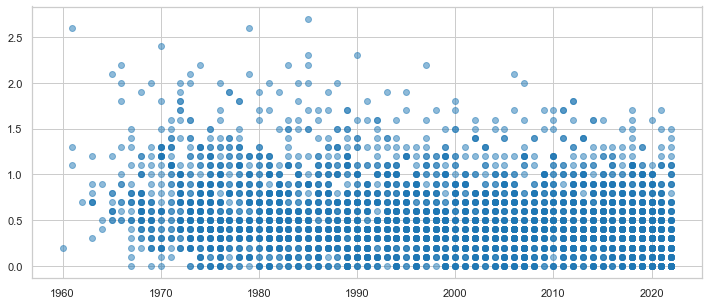

In [326]:
x = testing_merge['active_from']
y = testing_merge['steals_pg_RegS']
plt.scatter(x, y,  alpha=0.5)

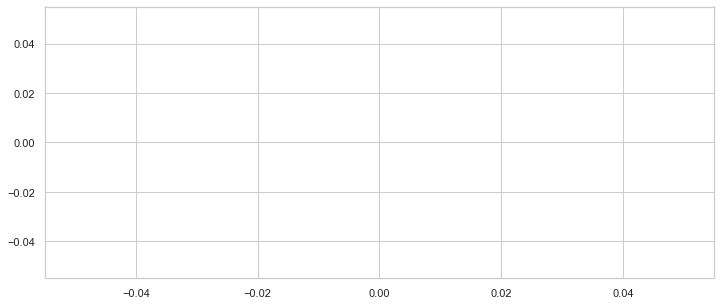

In [327]:
x = testing_merge[testing_merge['active_from']<1960]['active_from']
y = testing_merge[testing_merge['active_from']<1960]['steals_pg_RegS']
plt.scatter(x, y,  alpha=0.5)

In [328]:
len(testing_merge[testing_merge['active_from']<1960])

387

<AxesSubplot:ylabel='Frequency'>

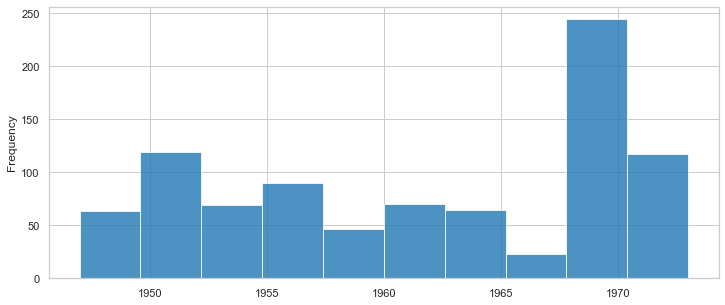

In [329]:
testing_merge[testing_merge['steals_pg_RegS'].isna()==True]['active_from'].plot.hist(alpha=0.8)

<AxesSubplot:ylabel='Frequency'>

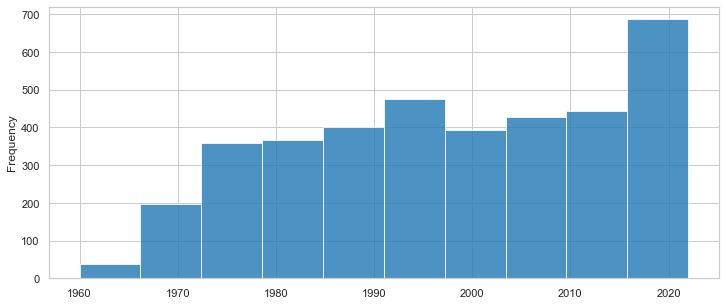

In [330]:
testing_merge[testing_merge['steals_pg_RegS'].isna()==False]['active_from'].plot.hist(alpha=0.8)

In [331]:
#aprox 20% of the data doesn't have steals registered so we'll drop the columns!!
df_complete_players_4 = df_complete_players_4.drop(columns=['steals_pg_RegS','steals_pg_Playoff'])

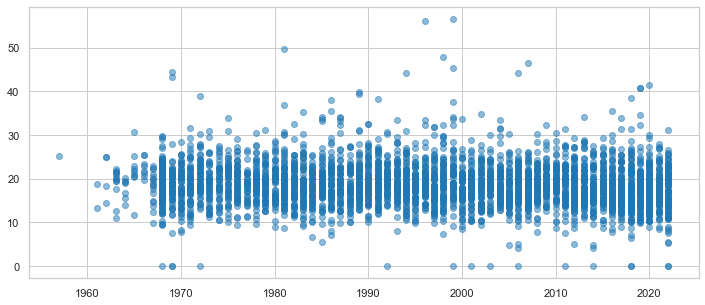

In [332]:
x = testing_merge['active_from']
y = testing_merge['usage_percent_RegS']
plt.scatter(x, y,  alpha=0.5)

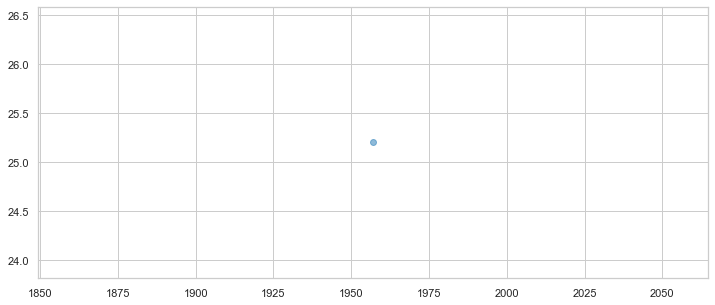

In [333]:
x = testing_merge[testing_merge['active_from']<1960]['active_from']
y = testing_merge[testing_merge['active_from']<1960]['usage_percent_RegS']
plt.scatter(x, y,  alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

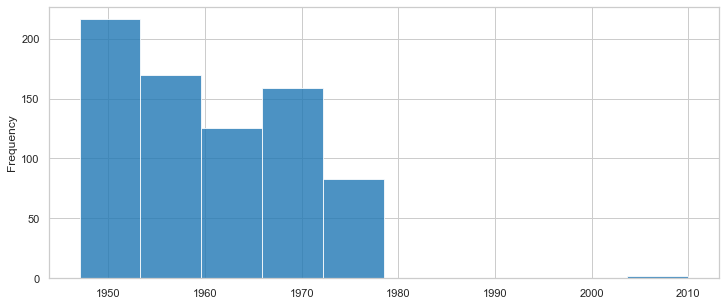

In [334]:
testing_merge[testing_merge['usage_percent_RegS'].isna()==True]['active_from'].plot.hist(alpha=0.8)

AxesSubplot(0.125,0.125;0.698618x0.755)
games_started_RegS                 0.000000
field_goals_attempts_pg_RegS       0.000000
field_goals_percent_pg_RegS        0.000000
_3pts_goals_attempts_pg_RegS       0.000000
FT_goals_attempts_pg_RegS          0.000000
FT_goals_percent_pg_RegS           0.000000
total_rebounds_pg_RegS             0.000000
assists_pg_RegS                    0.000000
personal_foults_pg_RegS            0.000000
points_pg_RegS                     0.000000
games_started_Playoff              0.395696
field_goals_attempts_pg_Playoff    0.395696
field_goals_percent_pg_Playoff     0.395696
_3pts_goals_attempts_pg_Playoff    0.395696
FT_goals_attempts_pg_Playoff       0.395696
FT_goals_percent_pg_Playoff        0.395696
total_rebounds_pg_Playoff          0.395696
assists_pg_Playoff                 0.395696
personal_foults_pg_Playoff         0.395696
points_pg_Playoff                  0.395696
FT_goals_attempts_total_RegS       0.000000
assists_total_RegS                 0

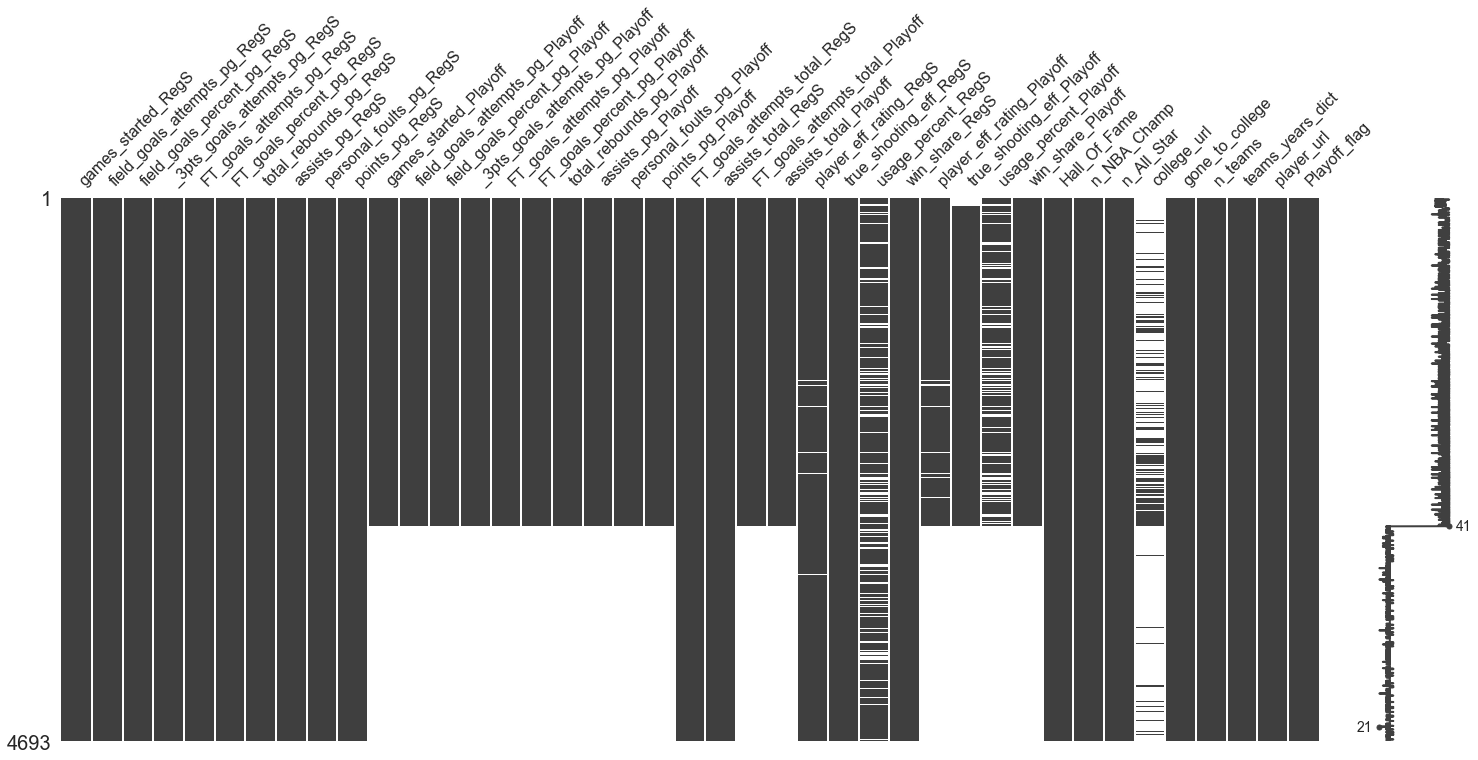

In [335]:
print(msno.matrix(df_complete_players_4.sort_values(by='field_goals_attempts_pg_Playoff')))
print(df_complete_players_4.isna().sum()/len(df_complete_players_4))

In [336]:
aux = df_complete_players_4[(df_complete_players_4['Playoff_flag']=='Yes')]
playoff_columns = aux.columns[(aux.isnull().any())]
playoff_columns

Index(['player_eff_rating_RegS', 'usage_percent_RegS',
       'player_eff_rating_Playoff', 'true_shooting_eff_Playoff',
       'usage_percent_Playoff', 'college_url'],
      dtype='object')

In [337]:
aux = df_complete_players_4[(df_complete_players_4['Playoff_flag']=='No')]
no_playoff_columns = aux.columns[(aux.isnull().any())]
no_playoff_columns

Index(['games_started_Playoff', 'field_goals_attempts_pg_Playoff',
       'field_goals_percent_pg_Playoff', '_3pts_goals_attempts_pg_Playoff',
       'FT_goals_attempts_pg_Playoff', 'FT_goals_percent_pg_Playoff',
       'total_rebounds_pg_Playoff', 'assists_pg_Playoff',
       'personal_foults_pg_Playoff', 'points_pg_Playoff',
       'FT_goals_attempts_total_Playoff', 'assists_total_Playoff',
       'player_eff_rating_RegS', 'true_shooting_eff_RegS',
       'usage_percent_RegS', 'win_share_RegS', 'player_eff_rating_Playoff',
       'true_shooting_eff_Playoff', 'usage_percent_Playoff',
       'win_share_Playoff', 'college_url'],
      dtype='object')

In [338]:
df_complete_players_4['college_url'] = df_complete_players_4['college_url'].fillna('')

In [339]:
# eliminar los que tienen dictionary de equipos = {}, porque juegan en equipos menores...
df_complete_players_5 = df_complete_players_4.copy()
df_complete_players_5 = df_complete_players_5[(df_complete_players_5['teams_years_dict']!='{}')]
print(len(df_complete_players_4))
print(len(df_complete_players_5))

4693
4671


## Hacer un knn con las columnas que quedan, filtrando por Playoff cuando necesario!!!

In [340]:
df_complete_players_6 = df_complete_players_5.copy()

df_complete_players_6 = df_complete_players_6.sort_values(by='field_goals_attempts_pg_Playoff')
df_complete_players_6_no_playoff = df_complete_players_6[df_complete_players_6['Playoff_flag']=='No']
df_complete_players_6_playoff = df_complete_players_6[df_complete_players_6['Playoff_flag']=='Yes']

AxesSubplot(0.125,0.125;0.698618x0.755)


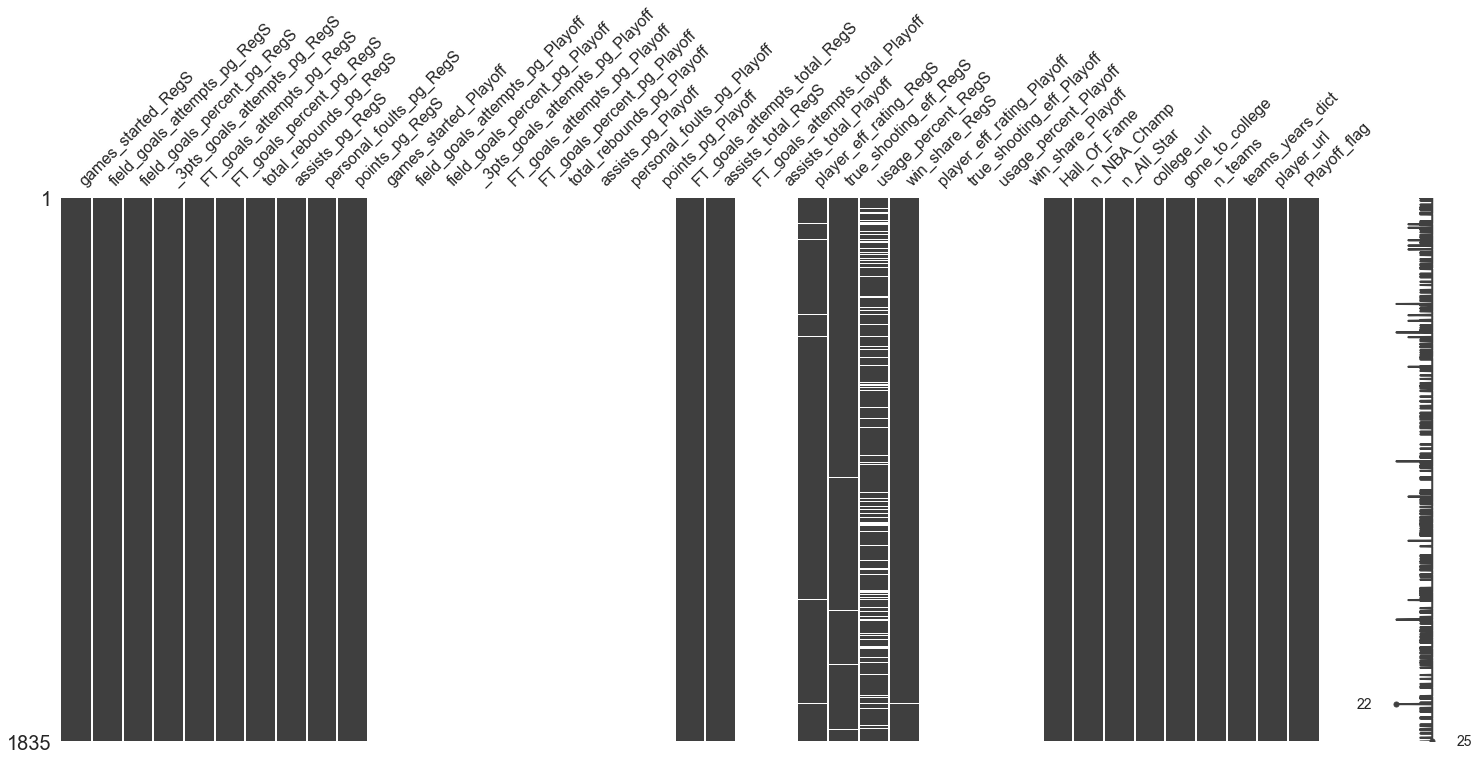

In [341]:
print(msno.matrix(df_complete_players_6_no_playoff))

In [342]:
RegS_imputer_columns = ['games_started_RegS', 'field_goals_attempts_pg_RegS',
       'field_goals_percent_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'personal_foults_pg_RegS',
       'FT_goals_attempts_total_RegS','assists_total_RegS', 'player_eff_rating_RegS',
       'true_shooting_eff_RegS', 'usage_percent_RegS', 'win_share_RegS', 'n_NBA_Champ', 'n_All_Star', 'n_teams']
#RegS_imputer_columns

In [343]:
#df_complete_players_6 = df_complete_players_5.copy()

imputer = KNNImputer(n_neighbors=10)
#imputed_data = imputer.fit_transform(df_complete_players_6[RegS_imputer_columns])
imputed_data = imputer.fit(df_complete_players_6_no_playoff[RegS_imputer_columns])
imputed_data = imputer.transform(df_complete_players_6_no_playoff[RegS_imputer_columns])
df_temp_new = pd.DataFrame(imputed_data)
df_temp_new.columns = RegS_imputer_columns
df_complete_players_6_no_playoff['player_eff_rating_RegS'] = df_temp_new['player_eff_rating_RegS'].to_list()
df_complete_players_6_no_playoff['usage_percent_RegS'] = df_temp_new['usage_percent_RegS'].to_list()
df_complete_players_6_no_playoff['true_shooting_eff_RegS'] = df_temp_new['true_shooting_eff_RegS'].to_list()
df_complete_players_6_no_playoff['win_share_RegS'] = df_temp_new['win_share_RegS'].to_list()

AxesSubplot(0.125,0.125;0.698618x0.755)


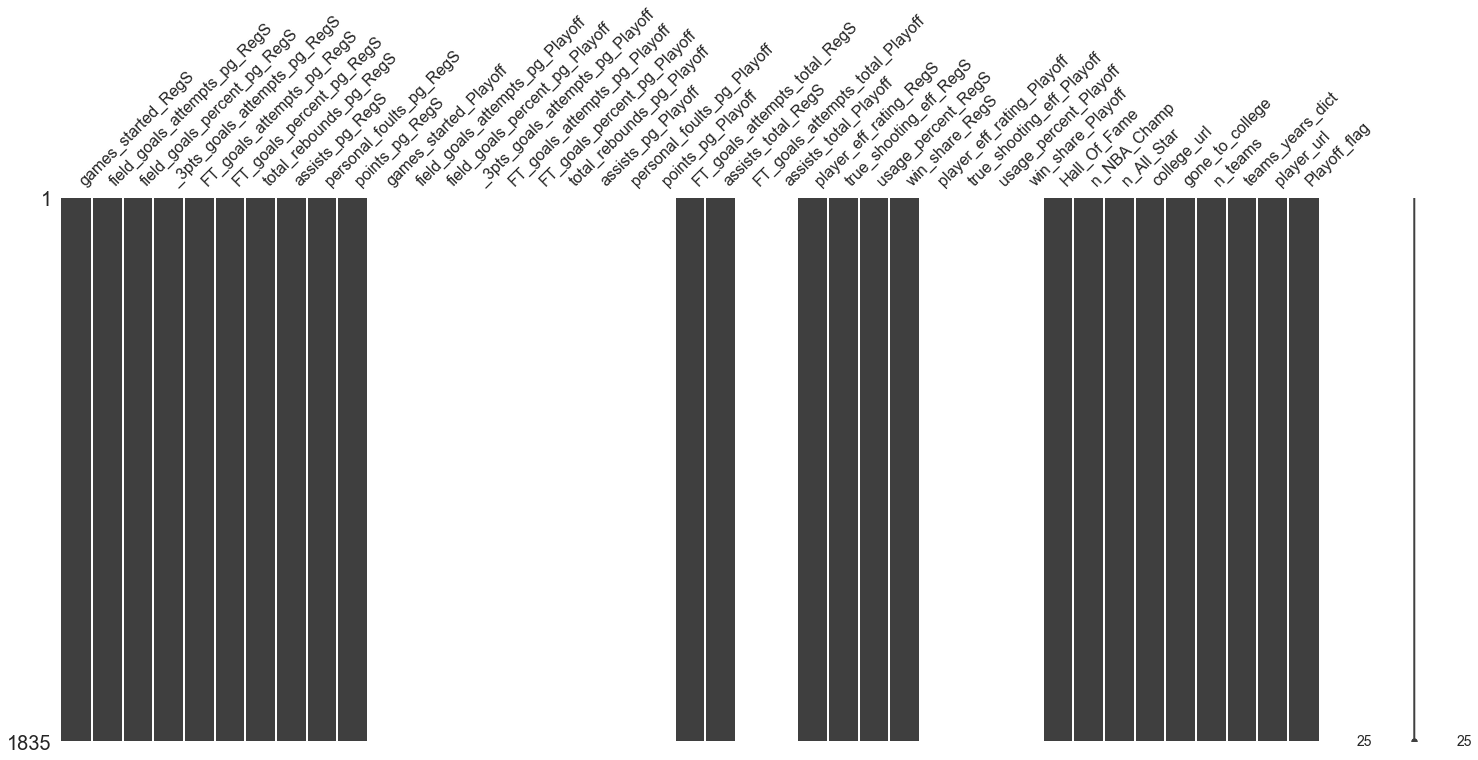

In [344]:
print(msno.matrix(df_complete_players_6_no_playoff))

In [345]:
Playoff_imputer_columns = ['games_started_RegS', 'field_goals_attempts_pg_RegS',
       'field_goals_percent_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'personal_foults_pg_RegS',
       'games_started_Playoff', 'field_goals_attempts_pg_Playoff',
       'field_goals_percent_pg_Playoff', '_3pts_goals_attempts_pg_Playoff',
       'FT_goals_attempts_pg_Playoff', 'FT_goals_percent_pg_Playoff',
       'total_rebounds_pg_Playoff', 'assists_pg_Playoff',
       'personal_foults_pg_Playoff', 'FT_goals_attempts_total_RegS',
       'assists_total_RegS', 'FT_goals_attempts_total_Playoff',
       'assists_total_Playoff', 'player_eff_rating_RegS',
       'true_shooting_eff_RegS', 'usage_percent_RegS', 'win_share_RegS', 'player_eff_rating_Playoff',
       'true_shooting_eff_Playoff', 'usage_percent_Playoff','win_share_Playoff', 'n_NBA_Champ',
        'n_All_Star', 'n_teams'] #combinamos los dos porque hace falta tener en cuenta que algunos tienen missing en RegS

AxesSubplot(0.125,0.125;0.698618x0.755)


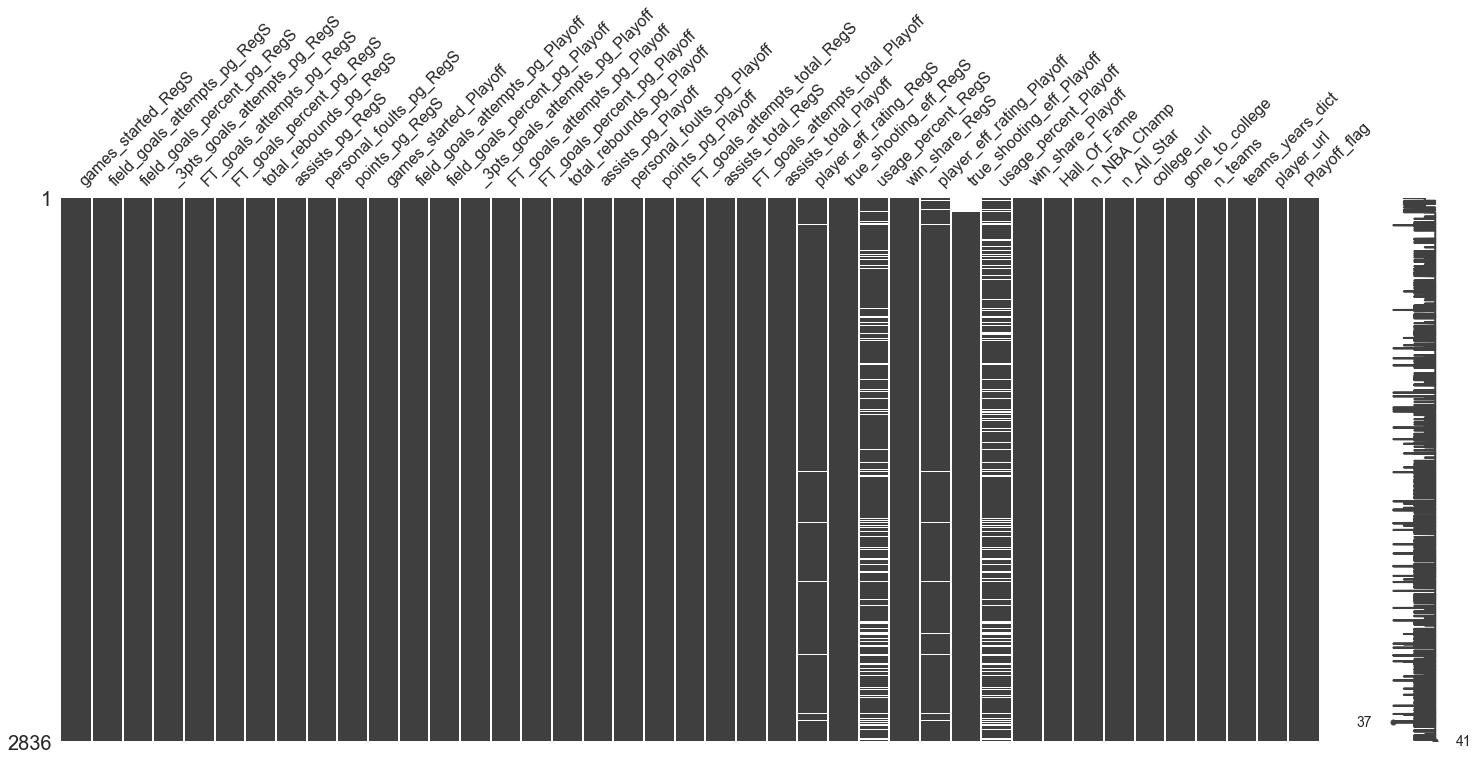

In [346]:
print(msno.matrix(df_complete_players_6_playoff))

In [347]:
#df_complete_players_6 = df_complete_players_5.copy()

imputer = KNNImputer(n_neighbors=10)
#imputed_data = imputer.fit_transform(df_complete_players_6[RegS_imputer_columns])
imputed_data = imputer.fit(df_complete_players_6_playoff[Playoff_imputer_columns])
imputed_data = imputer.transform(df_complete_players_6_playoff[Playoff_imputer_columns])
df_temp_new = pd.DataFrame(imputed_data)
df_temp_new.columns = Playoff_imputer_columns
df_complete_players_6_playoff['player_eff_rating_Playoff'] = df_temp_new['player_eff_rating_Playoff'].to_list()
df_complete_players_6_playoff['true_shooting_eff_Playoff'] = df_temp_new['true_shooting_eff_Playoff'].to_list()
df_complete_players_6_playoff['usage_percent_Playoff'] = df_temp_new['usage_percent_Playoff'].to_list()
df_complete_players_6_playoff['player_eff_rating_RegS'] = df_temp_new['player_eff_rating_RegS'].to_list()
df_complete_players_6_playoff['usage_percent_RegS'] = df_temp_new['usage_percent_RegS'].to_list()

AxesSubplot(0.125,0.125;0.698618x0.755)


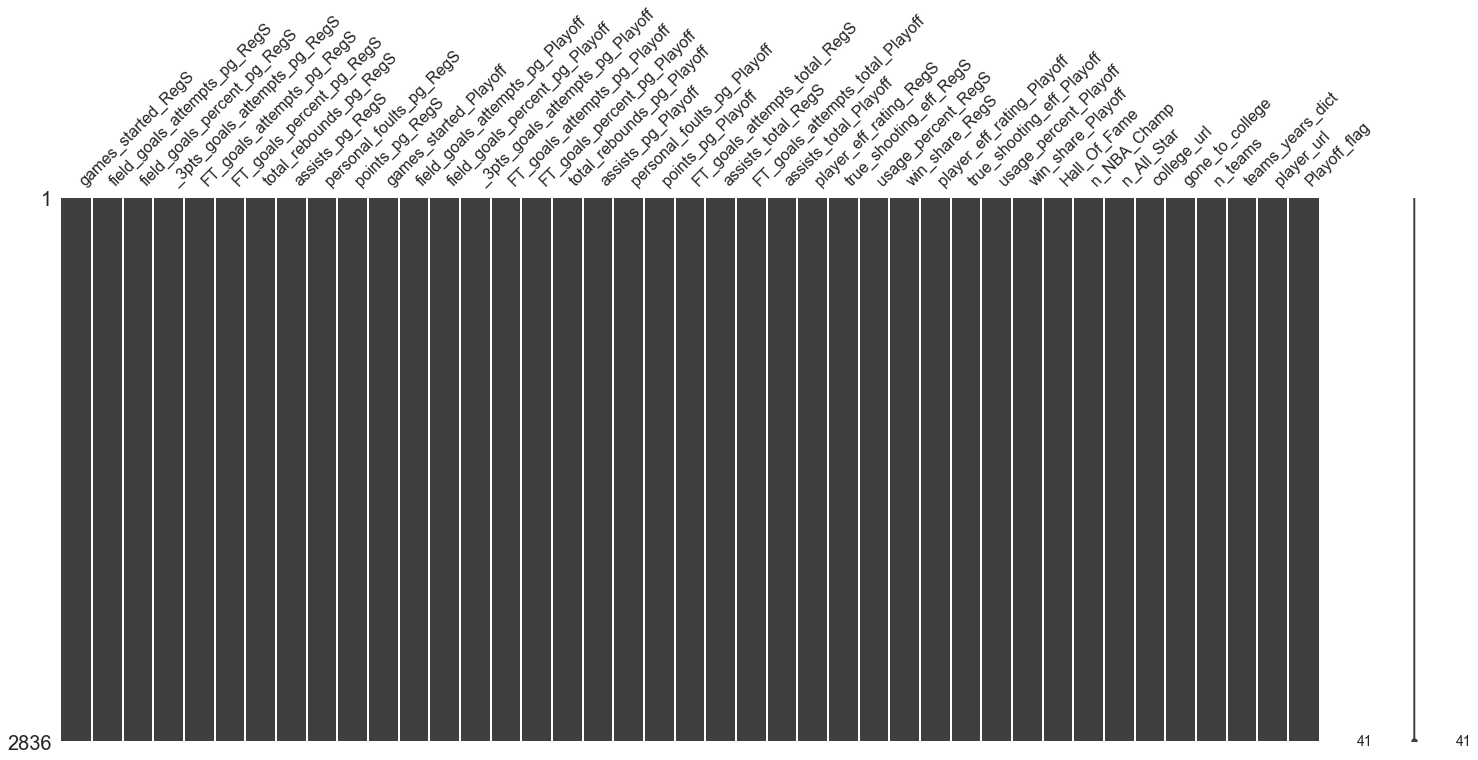

In [348]:
print(msno.matrix(df_complete_players_6_playoff))

AxesSubplot(0.125,0.125;0.698618x0.755)


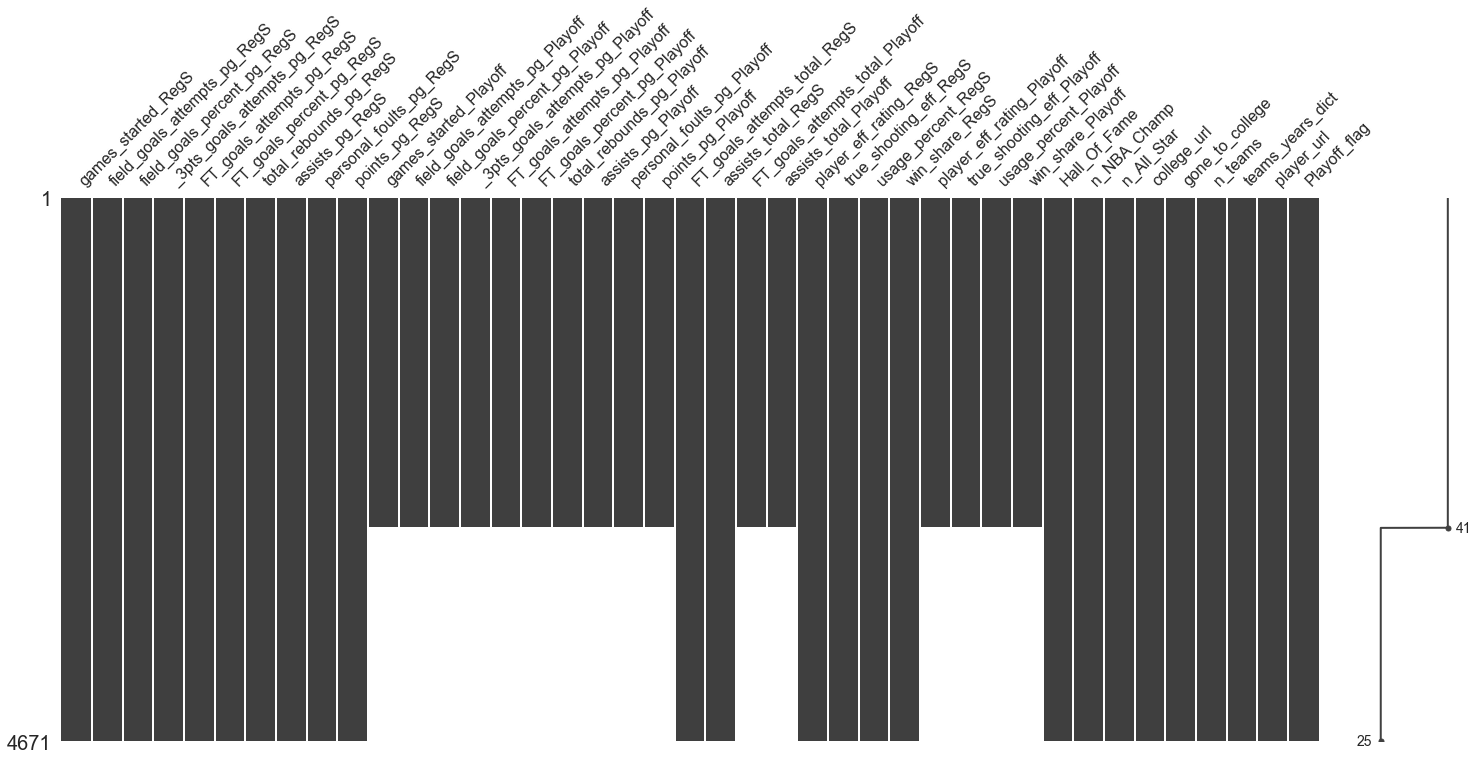

In [349]:
df_complete_players_7 = df_complete_players_6_playoff.append(df_complete_players_6_no_playoff)
print(msno.matrix(df_complete_players_7))

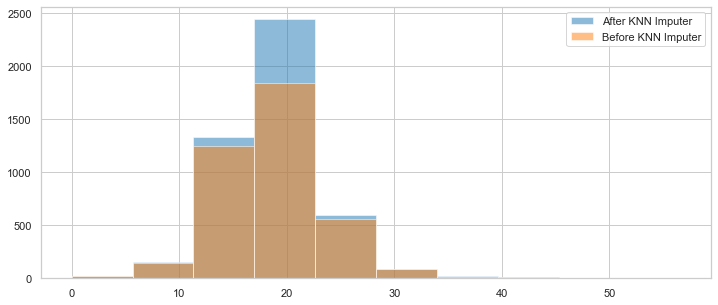

In [350]:
# RegS
#['player_eff_rating_RegS'] 
#['usage_percent_RegS'] 
#['true_shooting_eff_RegS'] 
#['win_share_RegS']

# Playoffs
#['player_eff_rating_Playoff']
#['true_shooting_eff_Playoff']
#['usage_percent_Playoff']
#['player_eff_rating_RegS']
#['usage_percent_RegS']

x = df_complete_players_7['usage_percent_RegS'] 
y = df_complete_players_6['usage_percent_RegS'] 

plt.hist(x, alpha=0.5, label='After KNN Imputer')
plt.hist(y, alpha=0.5, label='Before KNN Imputer')
plt.legend(loc='upper right')
plt.show()

In [351]:
df_complete_players_clean = df_complete_players_7.copy()
df_complete_players_clean = df_complete_players_clean.reset_index(drop=True)
df_complete_players_clean.to_excel('Clean_data/NBA_Complete_Clean.xlsx')

In [352]:
df_complete_players_clean.head()

games_started_RegS  field_goals_attempts_pg_RegS  \
0                 3.0                           3.0   
1                 0.0                           2.4   
2                 0.0                           3.5   
3                11.0                           2.4   
4                 2.0                           2.8   

   field_goals_percent_pg_RegS  _3pts_goals_attempts_pg_RegS  \
0                        0.434                           0.1   
1                        0.368                          -1.0   
2                        0.456                          -1.0   
3                        0.444                           0.1   
4                        0.433                           0.0   

   FT_goals_attempts_pg_RegS  FT_goals_percent_pg_RegS  \
0                        0.6                     0.672   
1                        0.9                     0.571   
2                        1.2                     0.774   
3                        0.7                     0.743   
4                        1.0                     0.613   

   total_rebounds_pg_RegS  assists_pg_RegS  personal_foults_pg_RegS  \
0                     2.4              1.3                      1.7   
1                     2.3              0.4                      2.3   
2                     0.6              1.4                      1.1   
3                     2.0              0.4                      2.3   
4                     2.4              0.3                      1.2   

   points_pg_RegS  ...  win_share_Playoff  Hall_Of_Fame  n_NBA_Champ  \
0             3.0  ...                0.0            No            0   
1             2.3  ...                0.0            No            0   
2             4.1  ...                0.0            No            0   
3             2.7  ...                0.0            No            0   
4             3.0  ...                0.0            No            0   

   n_All_Star  college_url  gone_to_college  n_teams  \
0           0                            No        1   
1           0                            No        1   
2           0                            No        1   
3           0                            No        5   
4           0                            No        3   

                                    teams_years_dict  \
0  {'team_0': ['Washington Bullets'], 'years_0': ...   
1  {'team_0': ['Baltimore Bullets'], 'years_0': [...   
2  {'team_0': ['Atlanta Hawks'], 'years_0': ['196...   
3  {'team_0': ['Detroit Pistons'], 'years_0': ['1...   
4  {'team_0': ['Los Angeles Clippers'], 'years_0'...   

                  player_url  Playoff_flag  
0  /players/t/terryca01.html           Yes  
1  /players/p/priddbo01.html           Yes  
2  /players/h/harlisk01.html           Yes  
3  /players/c/curlebi01.html           Yes  
4  /players/e/ellisle02.html           Yes  

[5 rows x 41 columns]

### 2.3 Un poco de data analysis con representación de variables...

In [353]:
#Ejemplo, tema de la evolución del % de triple a lo largo de la historia (dimensiones: nº jugadores, % triples, años)

In [354]:
# Algo con las posiciones del basic i el número de años a la liga. Por ejemplo, el recuento total, distribución por categoría a lo largo del tiempo (columnas apiladas....)